In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from heterogeneity_test.datasets import GSS, Polynomial, SinInteraction

params = {}

sns.set_theme(palette="colorblind", rc=params)

In [2]:
def plot_ate(df, df_sem, n, balance, method, ate=None):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7)) # Adjust figsize as needed
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    # Iterate over each subplot and plot the boxplot for each y variable
    ax = axes[0]  # Get the current Axes instance
    idx_df = (df["n"] == n) * (df["p(t)"] == balance)
    sns.boxplot(
        data=df[idx_df],
        hue="method",
        y="ate",
        gap=.1,
        showfliers=False,
        ax=ax,
    )
    ax.set_ylabel("ATE", fontsize='x-large') 
    ax.legend().remove()

    if ate is not None:
        ax.axhline(
            ate, 
            color="black", 
            linestyle='--', 
            linewidth=2, 
            # label=f'ATE True'
        )


    idx_df_sem = (df_sem["n"] == n) * (df_sem["p(t)"] == balance)
    ax = axes[1]
    sns.pointplot(
        data=df_sem[idx_df_sem], 
        x="method",
        y="ate_se", 
        hue="method",
        errorbar="se",
        ax=ax,
        capsize=.3,
    )
    ax.set_ylabel("ATE Emprirical Standard Error", fontsize='x-large') 
    ax.set_xticklabels([])
    ax.set_xlabel('')

    ax = axes[2]  # Get the current Axes instance
    sns.boxplot(
        data=df[idx_df],
        hue="method",
        y="r2-adj",
        gap=.1,
        showfliers=False,
        ax=ax,
    )
    ax.set_ylabel(r"Adjusted $R^2$", fontsize='x-large') 
    ax.legend().remove()

    # Set the legend outside the last axes (bottom right)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, 
        labels, 
        title='method', 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.15), 
        ncol=len(df['method'].unique()),
        fontsize='large', 
        title_fontsize='x-large',
    )
    fig.suptitle(f"{method}, P(T=1) = {balance}, N={n}", fontsize="x-large")
    # Show the plot
    plt.tight_layout()
    plt.show()


def plot_bias(df_sem, n, balance, method, ate=None):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7)) # Adjust figsize as needed
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration


    idx_df_sem = (df_sem["n"] == n) * (df_sem["p(t)"] == balance)
    ax = axes[0]
    sns.pointplot(
        data=df_sem[idx_df_sem], 
        x="method",
        y="bias", 
        hue="method",
        errorbar="se",
        ax=ax,
        capsize=.3,
    )
    ax.set_ylabel("ATE Emprirical Bias", fontsize='x-large') 
    ax.set_xticklabels([])
    ax.set_xlabel('')

    ax = axes[1]
    sns.pointplot(
        data=df_sem[idx_df_sem], 
        x="method",
        y="variance", 
        hue="method",
        errorbar="se",
        ax=ax,
        capsize=.3,
    )
    ax.set_ylabel("ATE Emprirical Variance", fontsize='x-large') 
    ax.set_xticklabels([])
    ax.set_xlabel('')

    df_sem["MSE"] = df_sem["bias"] + df_sem["variance"]

    ax = axes[2]
    sns.pointplot(
        data=df_sem[idx_df_sem], 
        x="method",
        y="MSE", 
        hue="method",
        errorbar="se",
        ax=ax,
        capsize=.3,
    )
    ax.set_ylabel("ATE Emprirical MSE", fontsize='x-large') 
    ax.set_xticklabels([])
    ax.set_xlabel('')

    fig.suptitle(f"{method}, P(T=1) = {balance}, N={n}", fontsize="x-large")
    # Show the plot
    plt.tight_layout()
    plt.show()

# GSS

In [38]:
ds = GSS(data_dir="data")
ate_true = ds.y[ds.z == 1].mean() - ds.y[ds.z == 0].mean()

In [39]:
base_dir = Path(f"experiments/ATE/GSS/")
df = pd.DataFrame()
df_sem = pd.DataFrame()
n = 2000
balances = [
    0.2, 
    0.5,
]
num_sims = 63
num_reps = 100
methods = [
    "DIM", 
    "OLS",
    "OLS-Lasso",
    "Lin", 
    "Lin-Lasso",
    "CausalForest",
    "GP",
]
for method in methods:
    for balance in balances:
        for seed in range(num_sims):
            exp_str = f"n={n}_balance={balance}_num-reps={num_reps}_seed={seed}"
            p = base_dir / f"{method}" / exp_str
            df = pd.concat([df, pd.read_csv(p / "results.csv")], axis=0)
            df_sem = pd.concat([df_sem, pd.read_csv(p / "results_sem.csv")], axis=0)

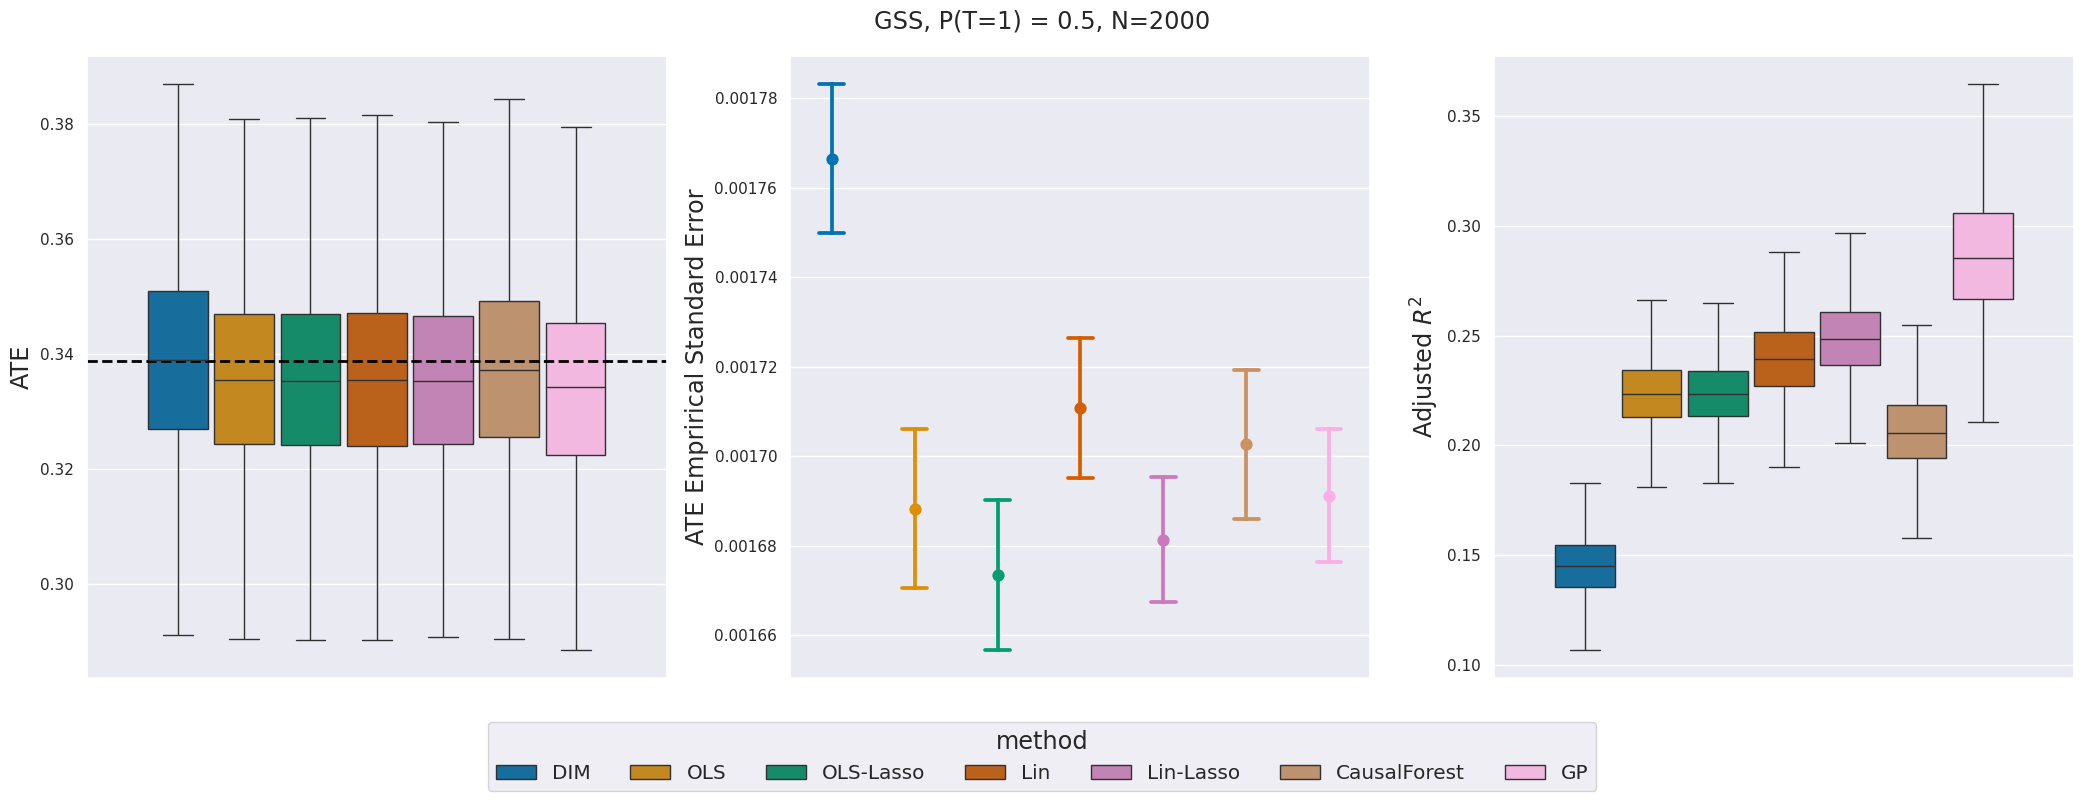

In [40]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=2000,
    balance=0.5,
    method="GSS",
    ate=ate_true,
)

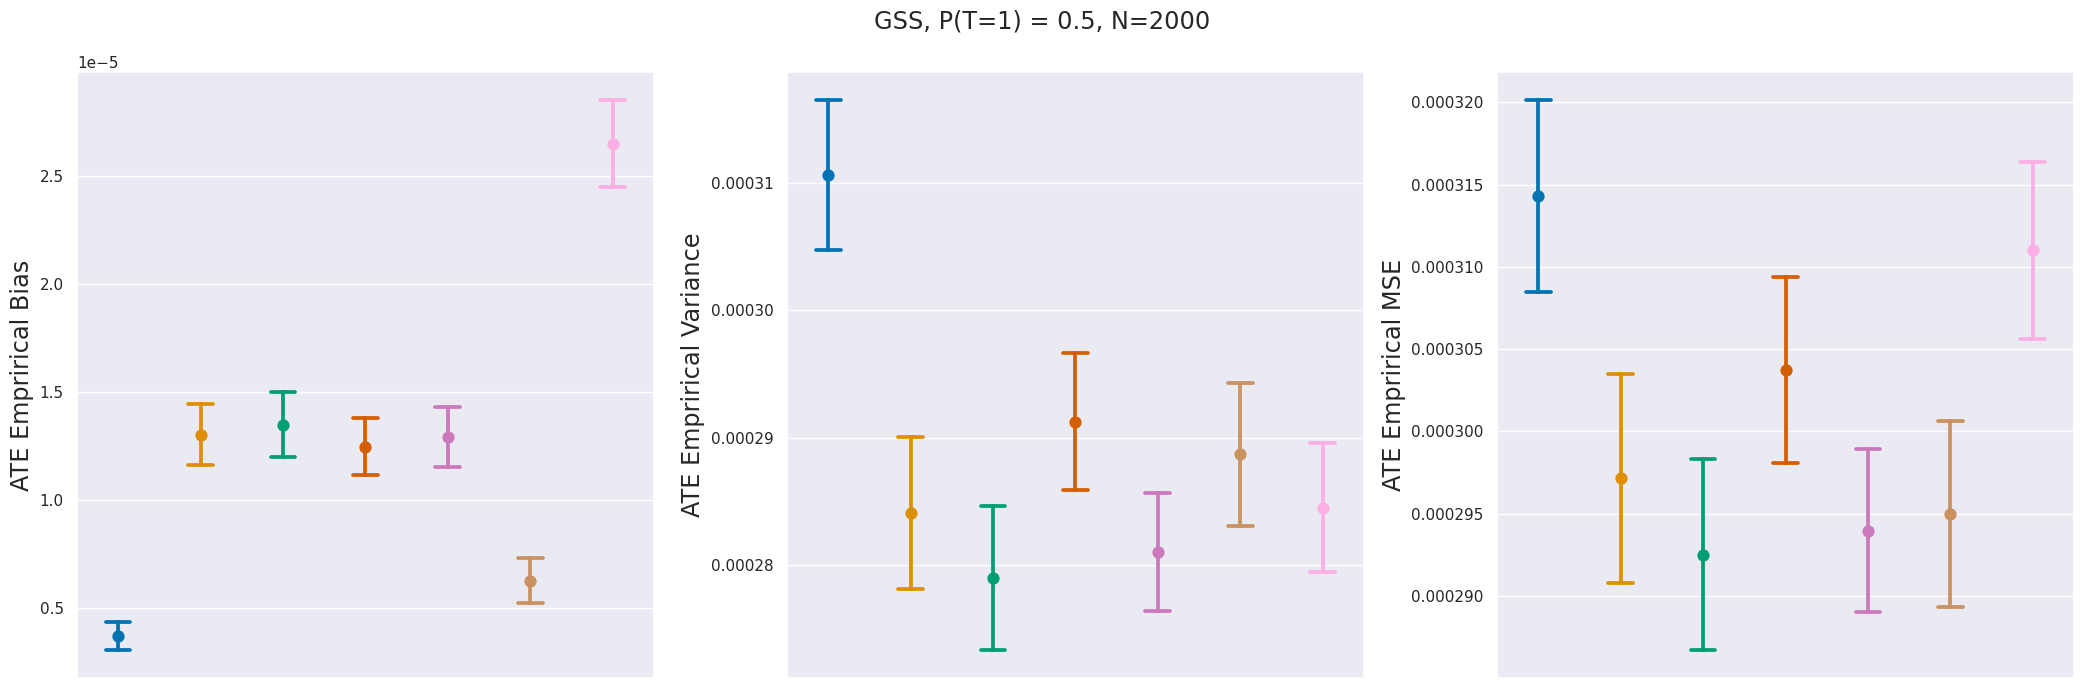

In [41]:
plot_bias(
    df_sem=df_sem,
    n=2000,
    balance=0.5,
    method="GSS",
)

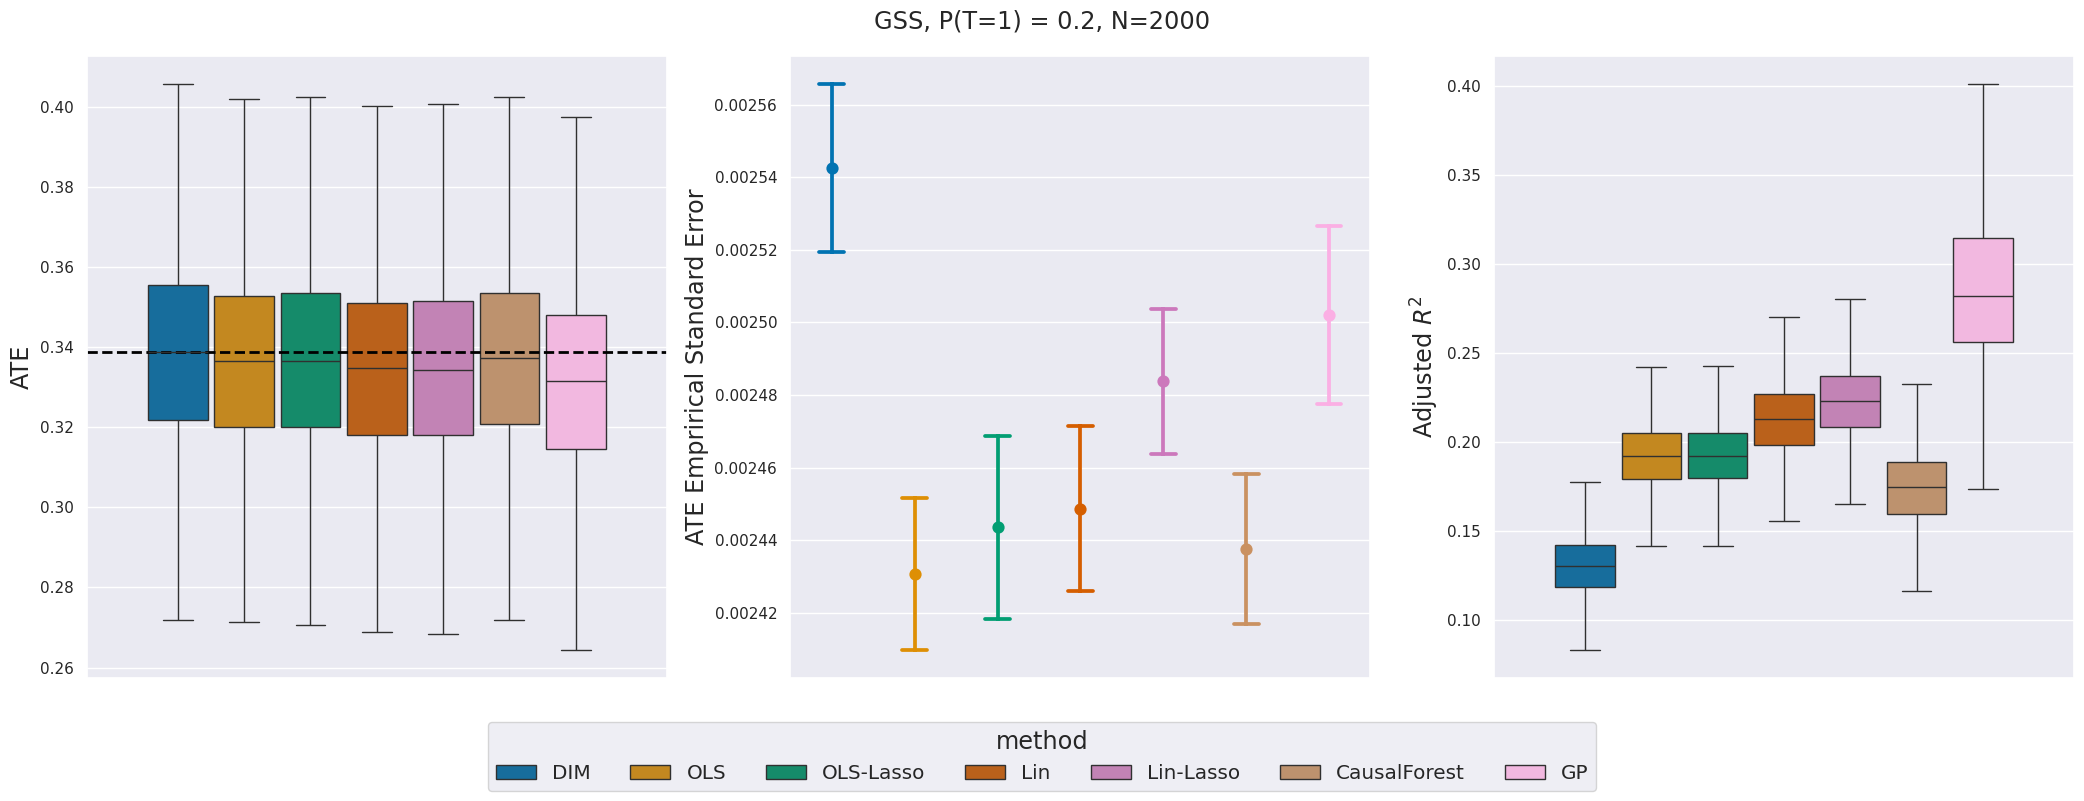

In [42]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=2000,
    balance=0.2,
    method="GSS",
    ate=ate_true,
)

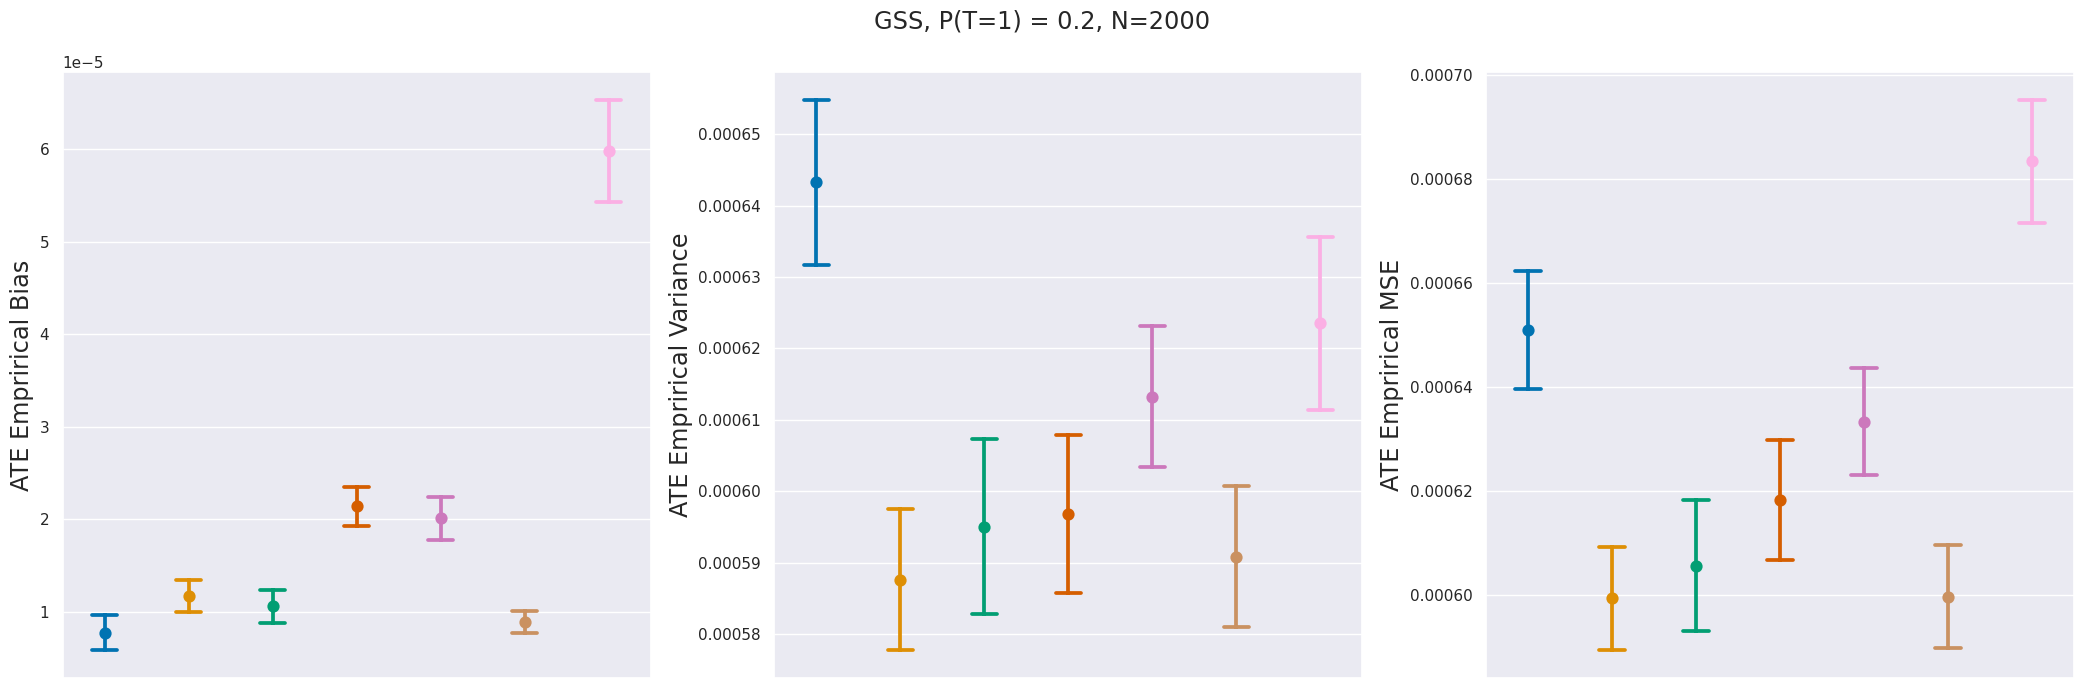

In [43]:
plot_bias(
    df_sem=df_sem,
    n=2000,
    balance=0.2,
    method="GSS",
)

# Polynomial

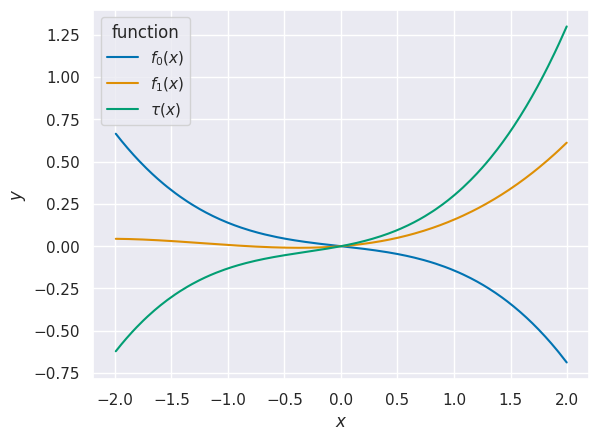

In [65]:
n = 10000000
ds = Polynomial(
    n=n,
    d=1,
    slope=0.1,
    sigma=0.1,
    balance=0.5,
    degree=3,
    beta_seed=1331,
)
x, z, y = ds.sample(seed=seed)

df_0 = pd.DataFrame()
df_0[r"$x$"] = x[:500, 0]
df_0[r"$y$"] = ds.mu0(x[:500])
df_0["function"] = [r"$f_0(x)$"]* 500
df_1 = pd.DataFrame()
df_1[r"$x$"] = x[:500, 0]
df_1[r"$y$"] = ds.mu1(x[:500])
df_1["function"] = [r"$f_1(x)$"]* 500
df_tau = pd.DataFrame()
df_tau[r"$x$"] = x[:500, 0]
df_tau[r"$y$"] = ds.tau[:500]
df_tau["function"] = [r"$\tau(x)$"]* 500
df = pd.concat([df_0, df_1, df_tau], axis=0)

_ = sns.lineplot(
    df, 
    x=r"$x$", 
    y=r"$y$",
    hue="function",
)
ate_true = ds.tau.mean()

## GRF

In [67]:
base_dir = Path(f"experiments/ATE/Polynomial/")
df = pd.DataFrame()
df_sem = pd.DataFrame()
ns = [
    200,
    500,
    1000,
    10000,
    100000,
]
balances = [
    0.5,
]
num_sims = 90
num_reps = 100
methods = [
    "OLS-Unadjusted", 
    "OLS-Adjusted",
    "OLS-Interact", 
    "GRF-Adjusted",
    "GRF-Interact", 
    # "CausalForest", 
    # "GRF", 
    # "GP-Adjusted",
    # "GP-Interact",
]
for n in ns:
    for method in methods:
        for balance in balances:
            for seed in range(num_sims):
                exp_str = f"n={n}_balance={balance}_num-reps={num_reps}_seed={seed}"
                p = base_dir / f"{method}" / exp_str
                df = pd.concat([df, pd.read_csv(p / "results.csv")], axis=0)
                df_sem = pd.concat([df_sem, pd.read_csv(p / "results_sem.csv")], axis=0)

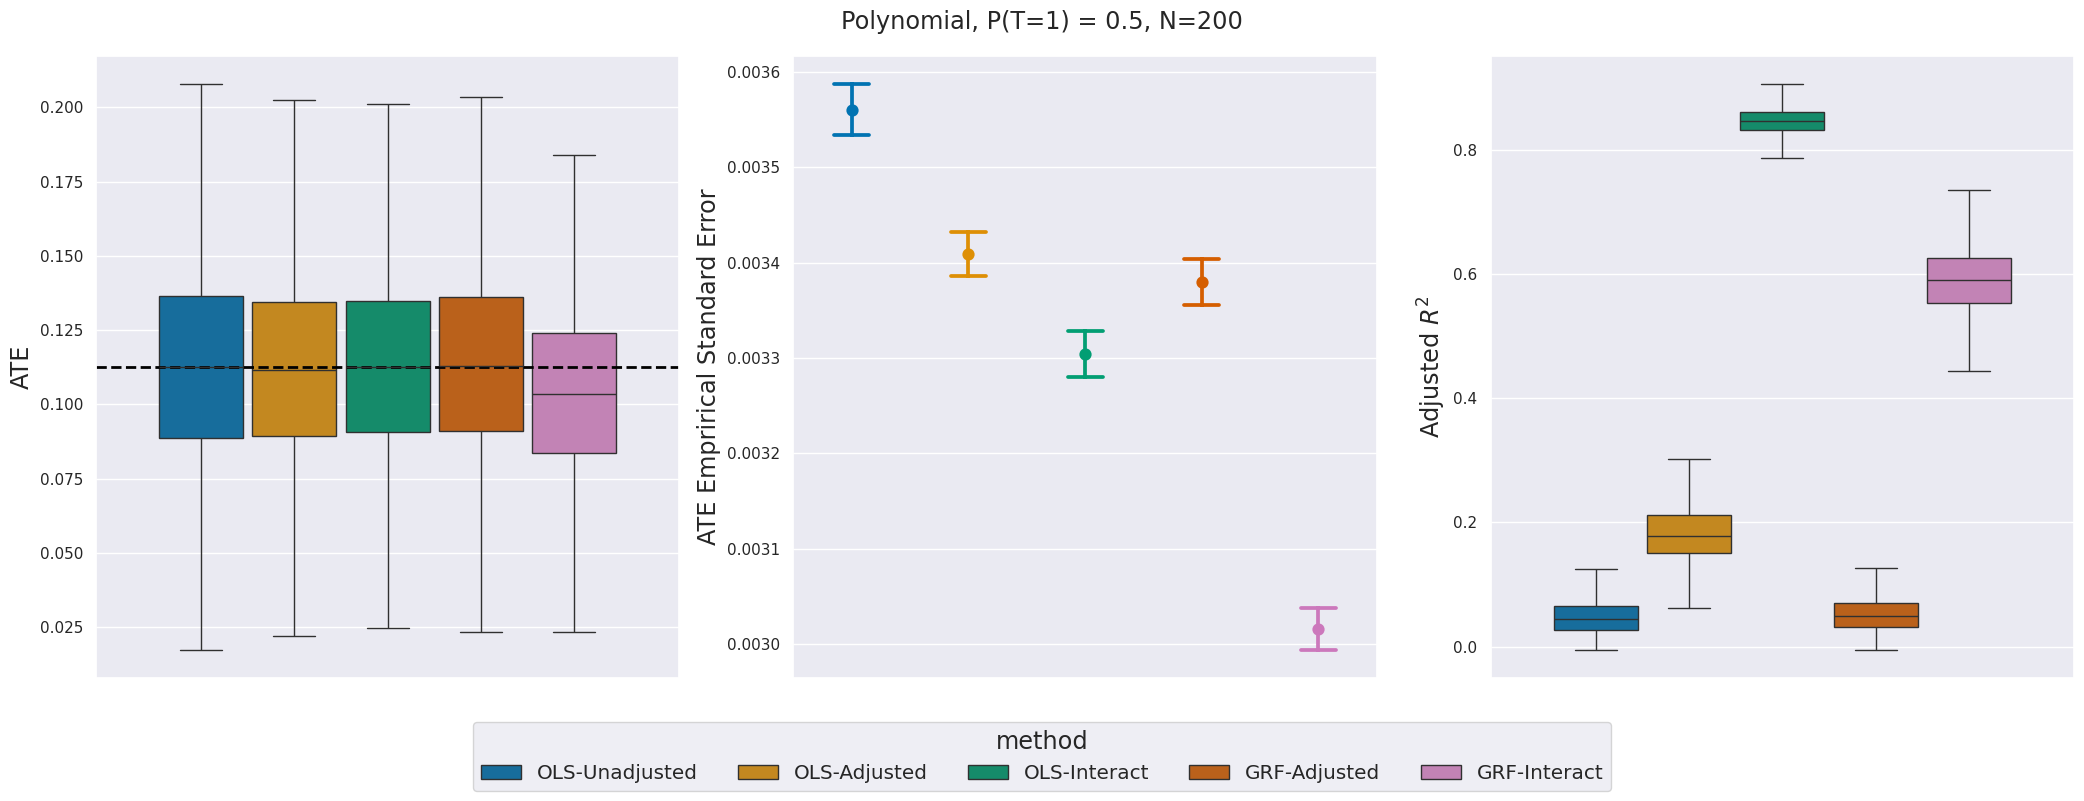

In [68]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=200,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

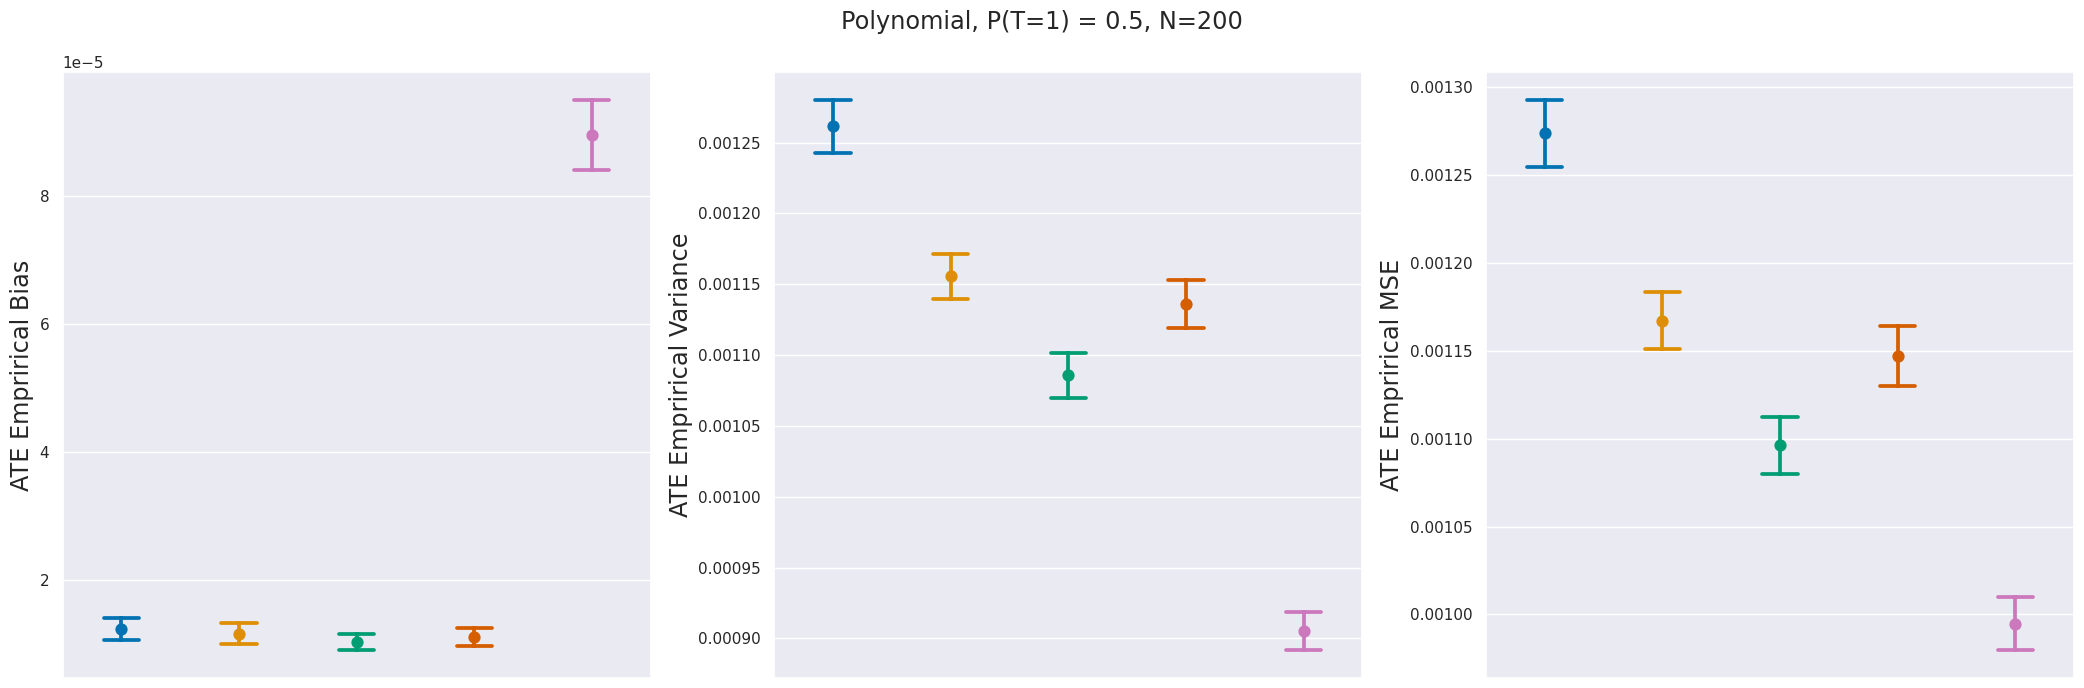

In [69]:
plot_bias(
    df_sem=df_sem,
    n=200,
    balance=0.5,
    method="Polynomial",
)

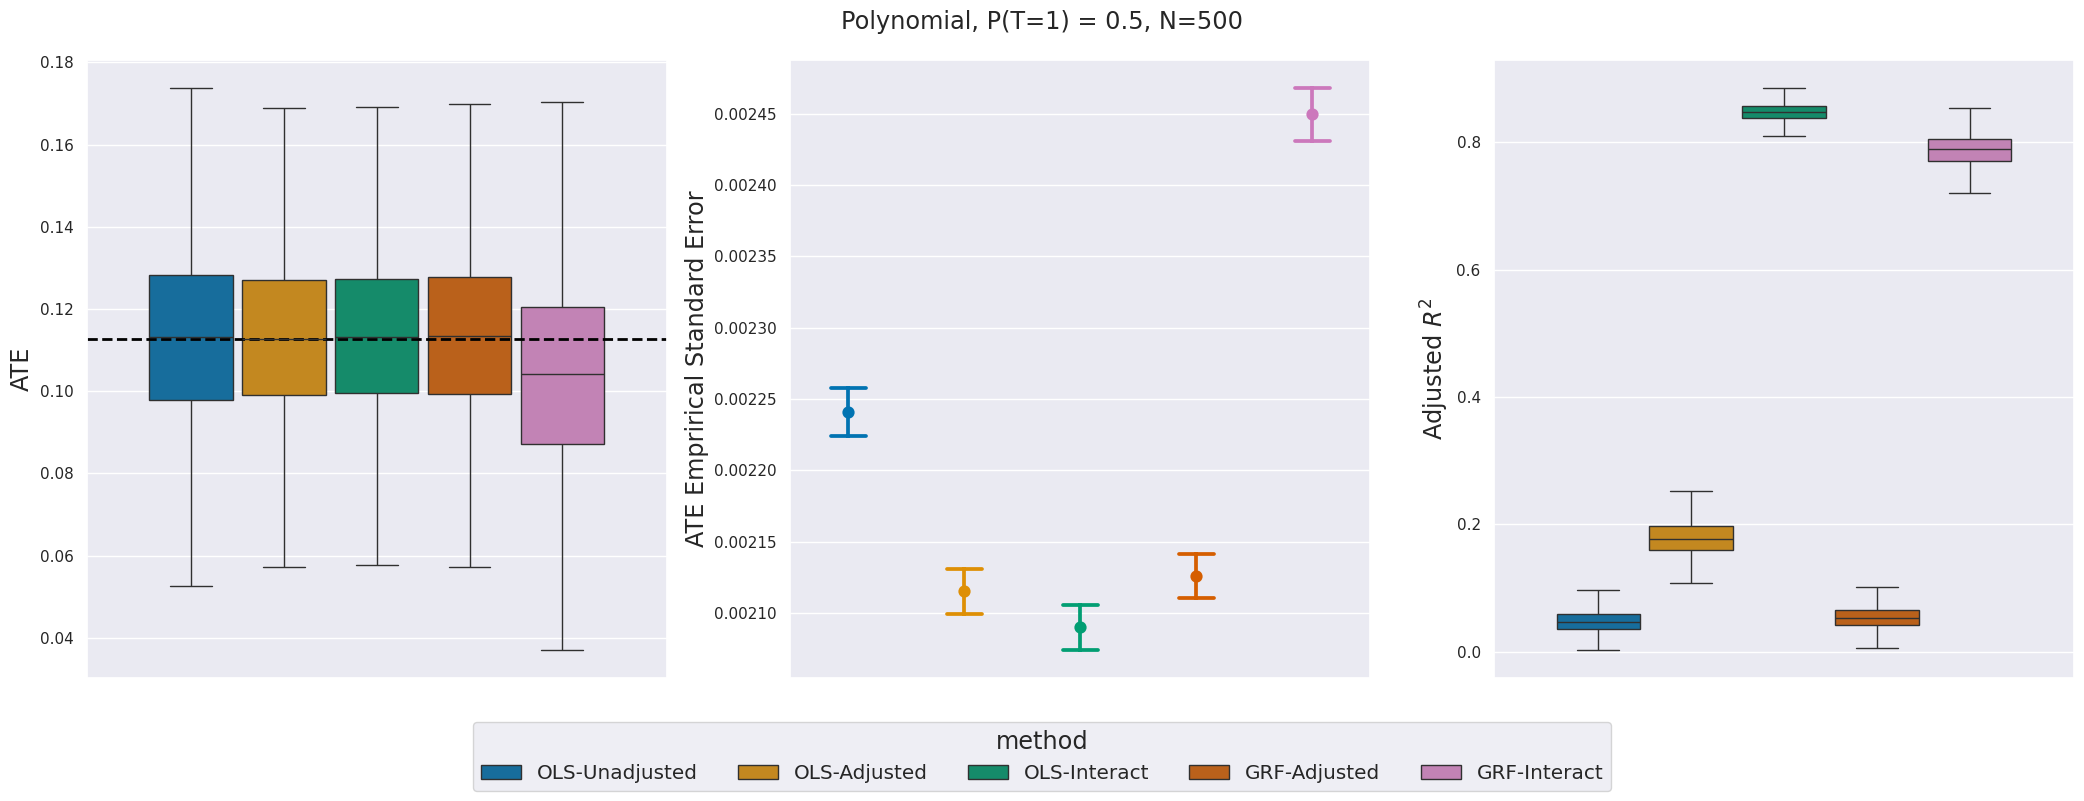

In [70]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=500,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

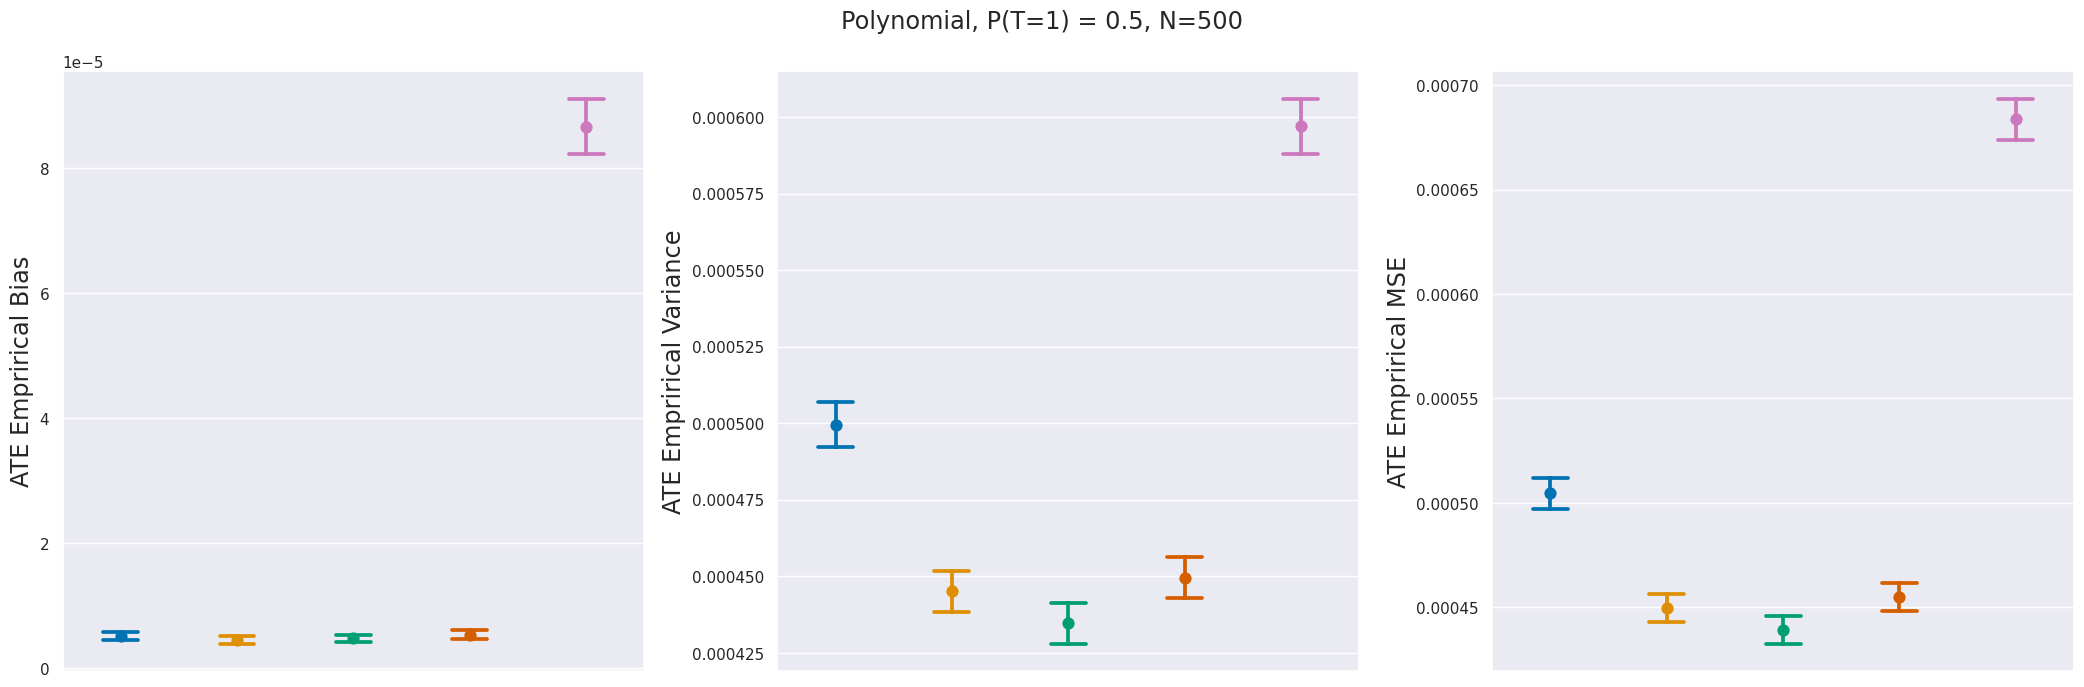

In [71]:
plot_bias(
    df_sem=df_sem,
    n=500,
    balance=0.5,
    method="Polynomial",
)

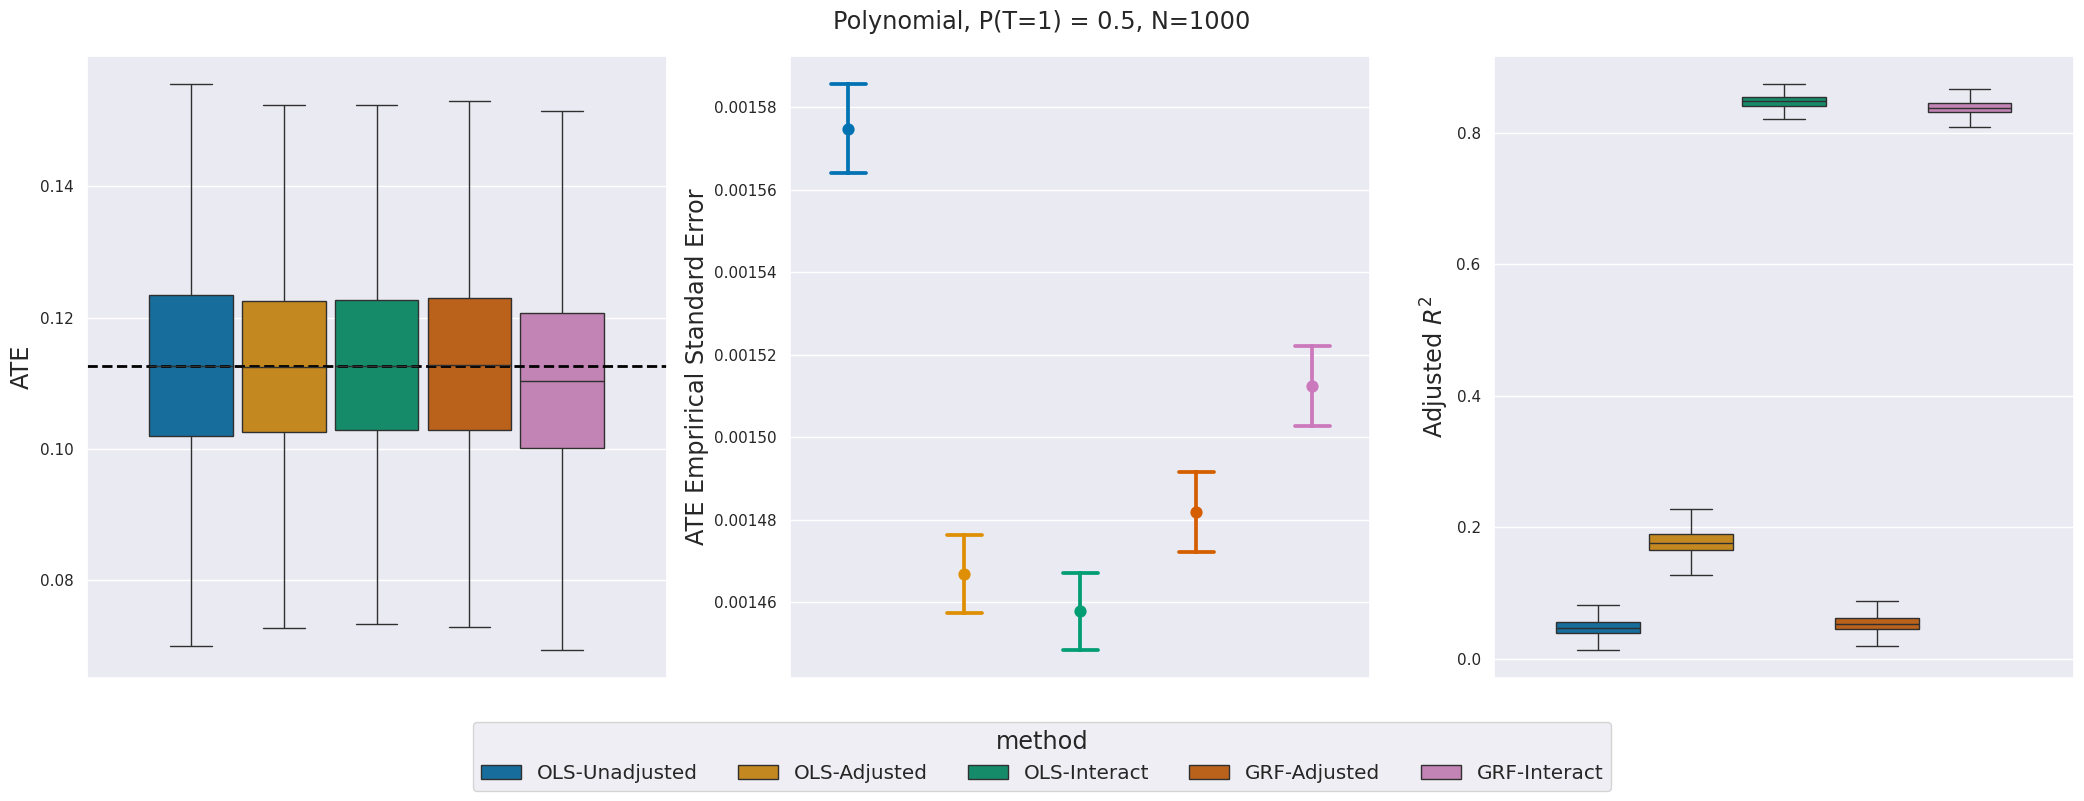

In [72]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=1000,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

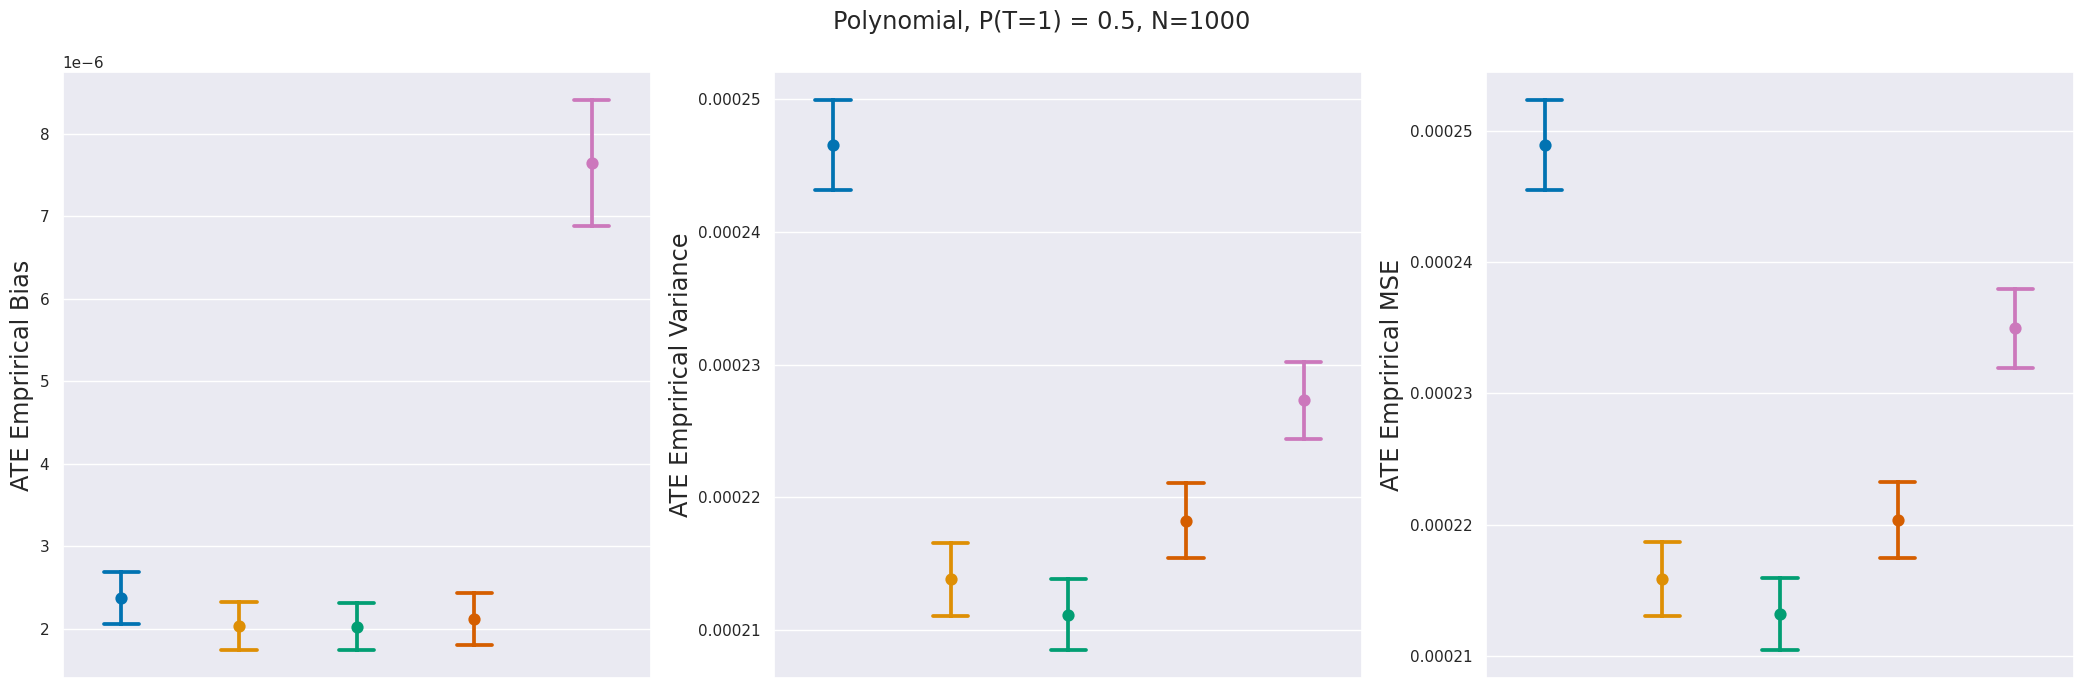

In [73]:
plot_bias(
    df_sem=df_sem,
    n=1000,
    balance=0.5,
    method="Polynomial",
)

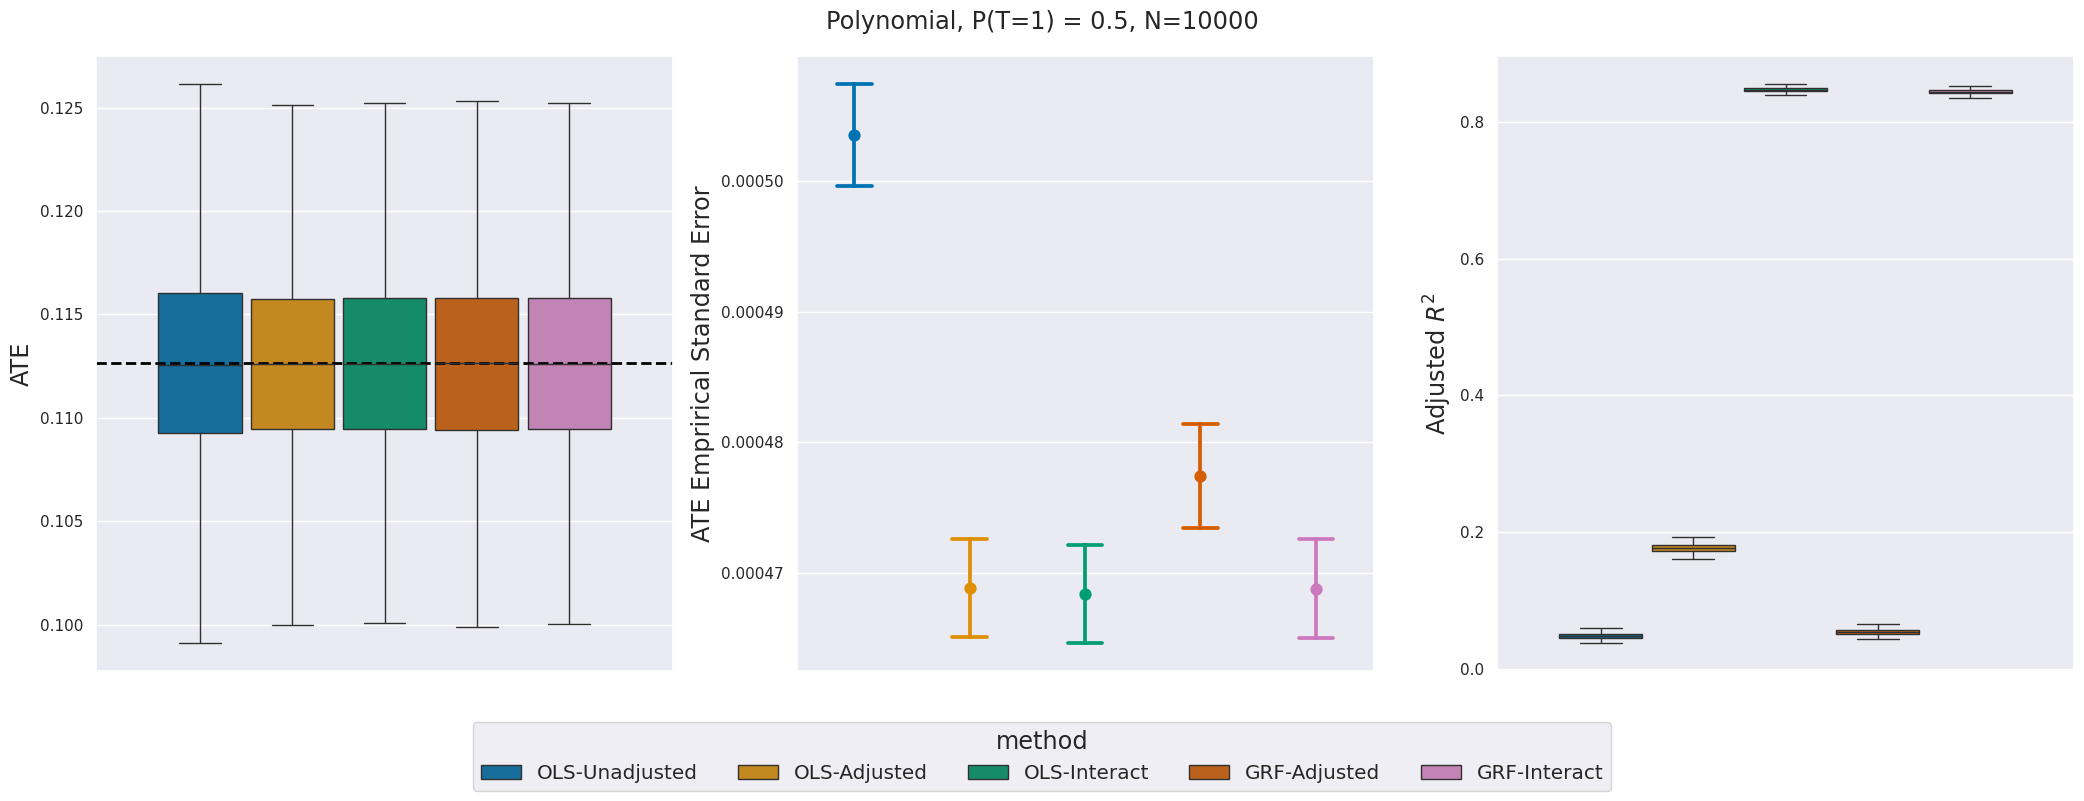

In [74]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=10000,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

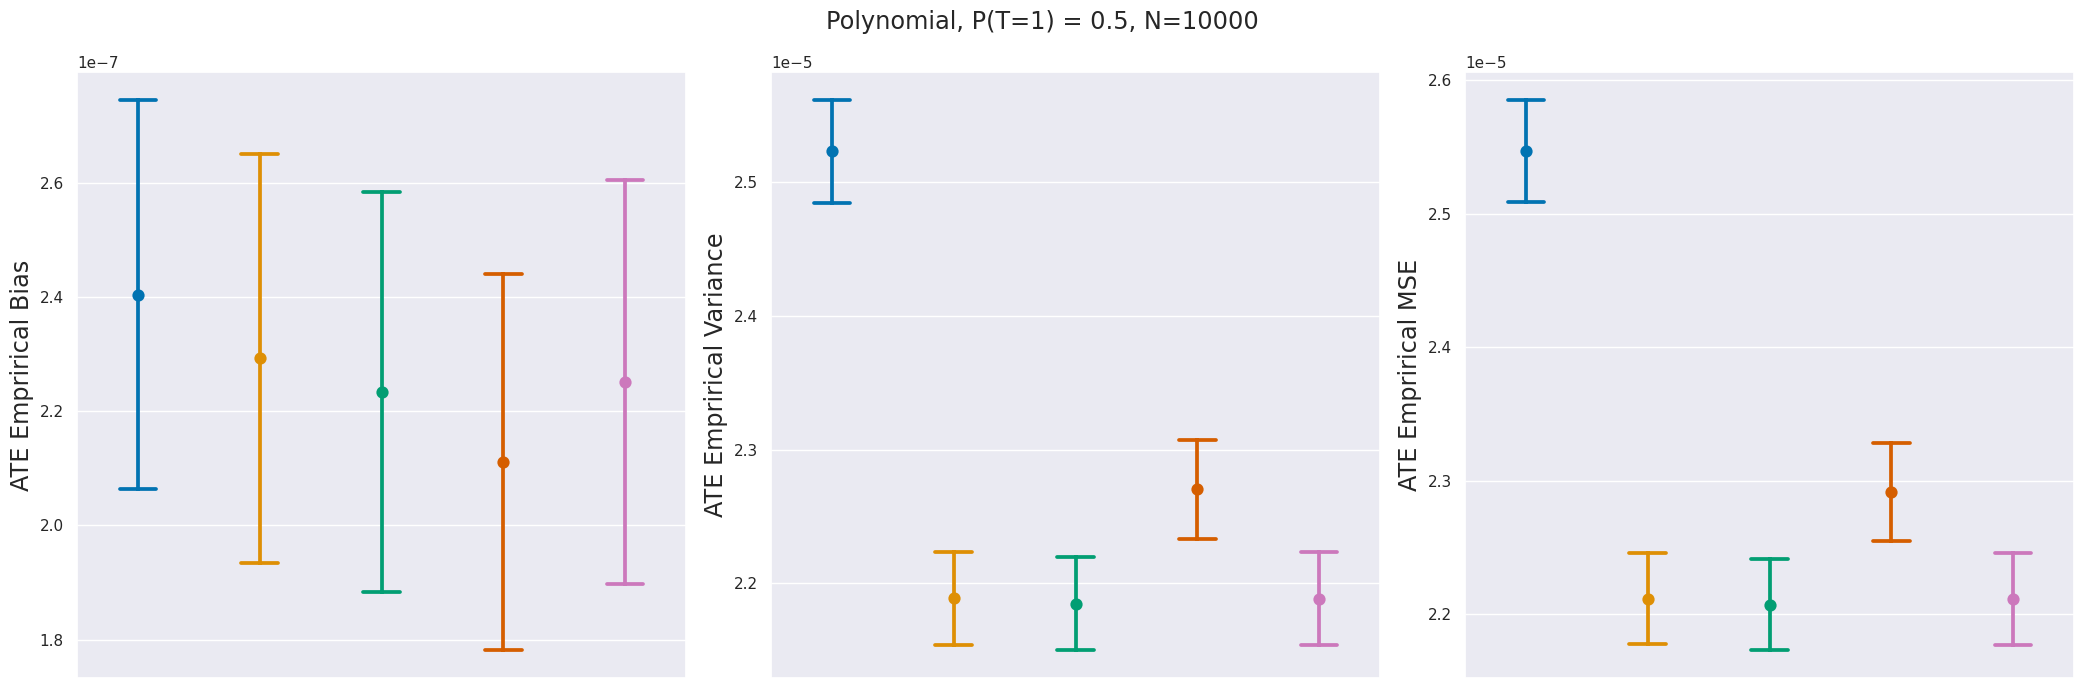

In [75]:
plot_bias(
    df_sem=df_sem,
    n=10000,
    balance=0.5,
    method="Polynomial",
)

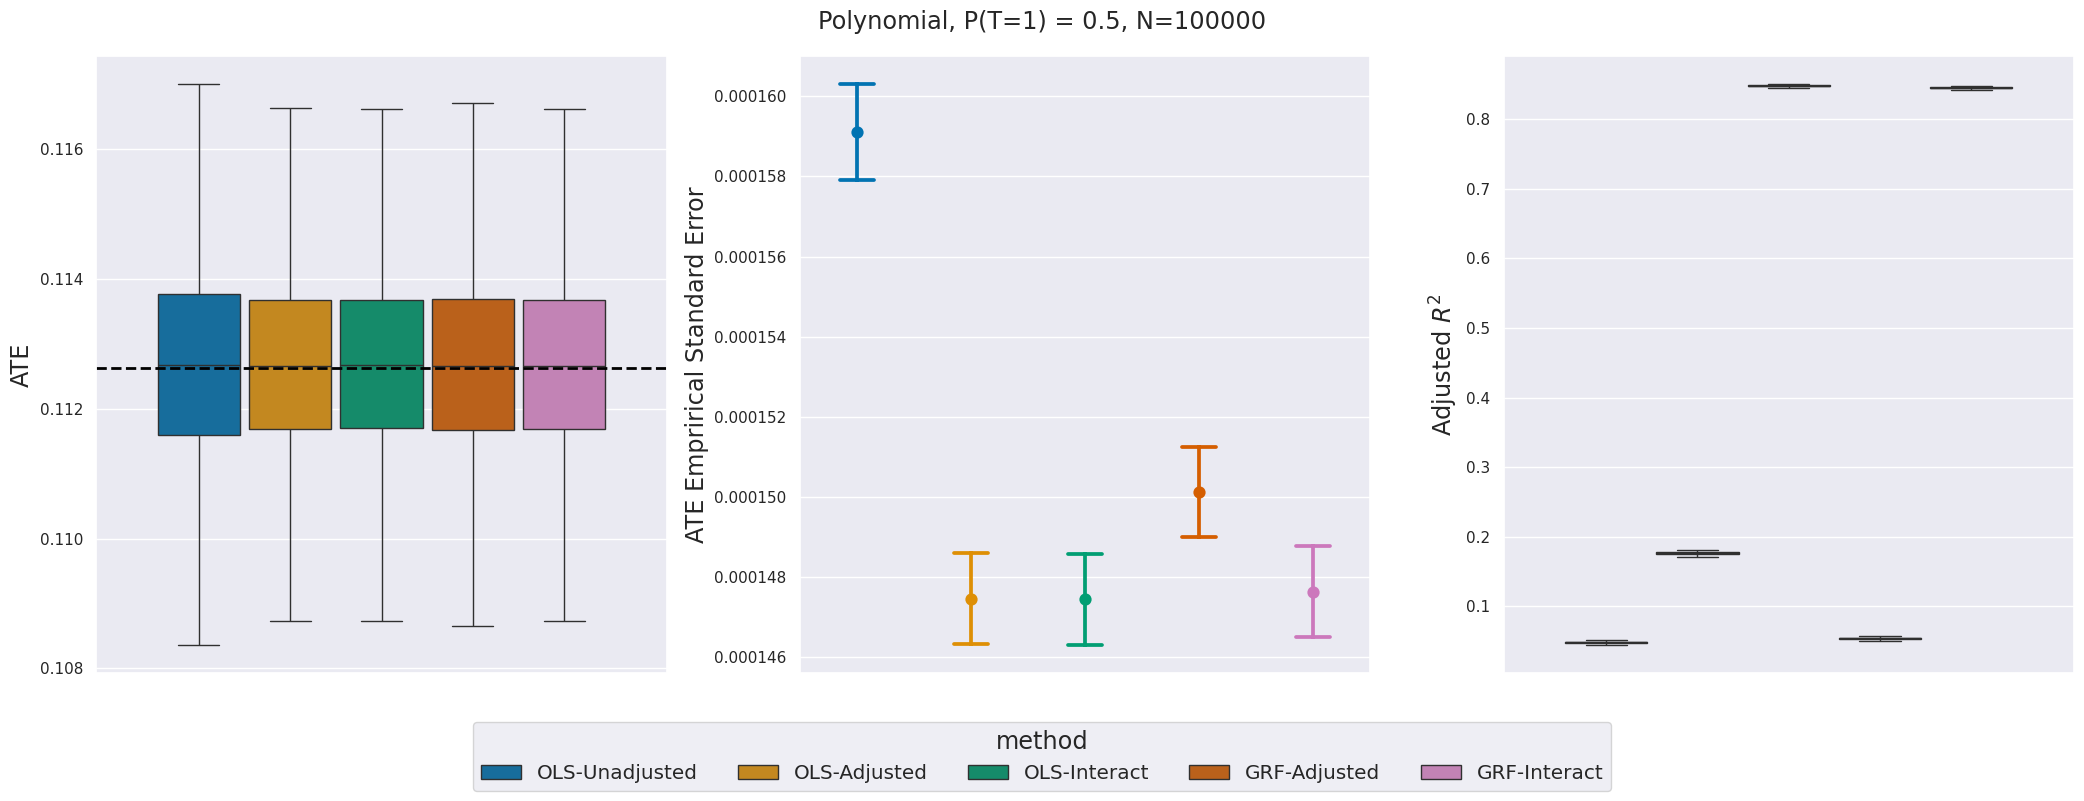

In [76]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=100000,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

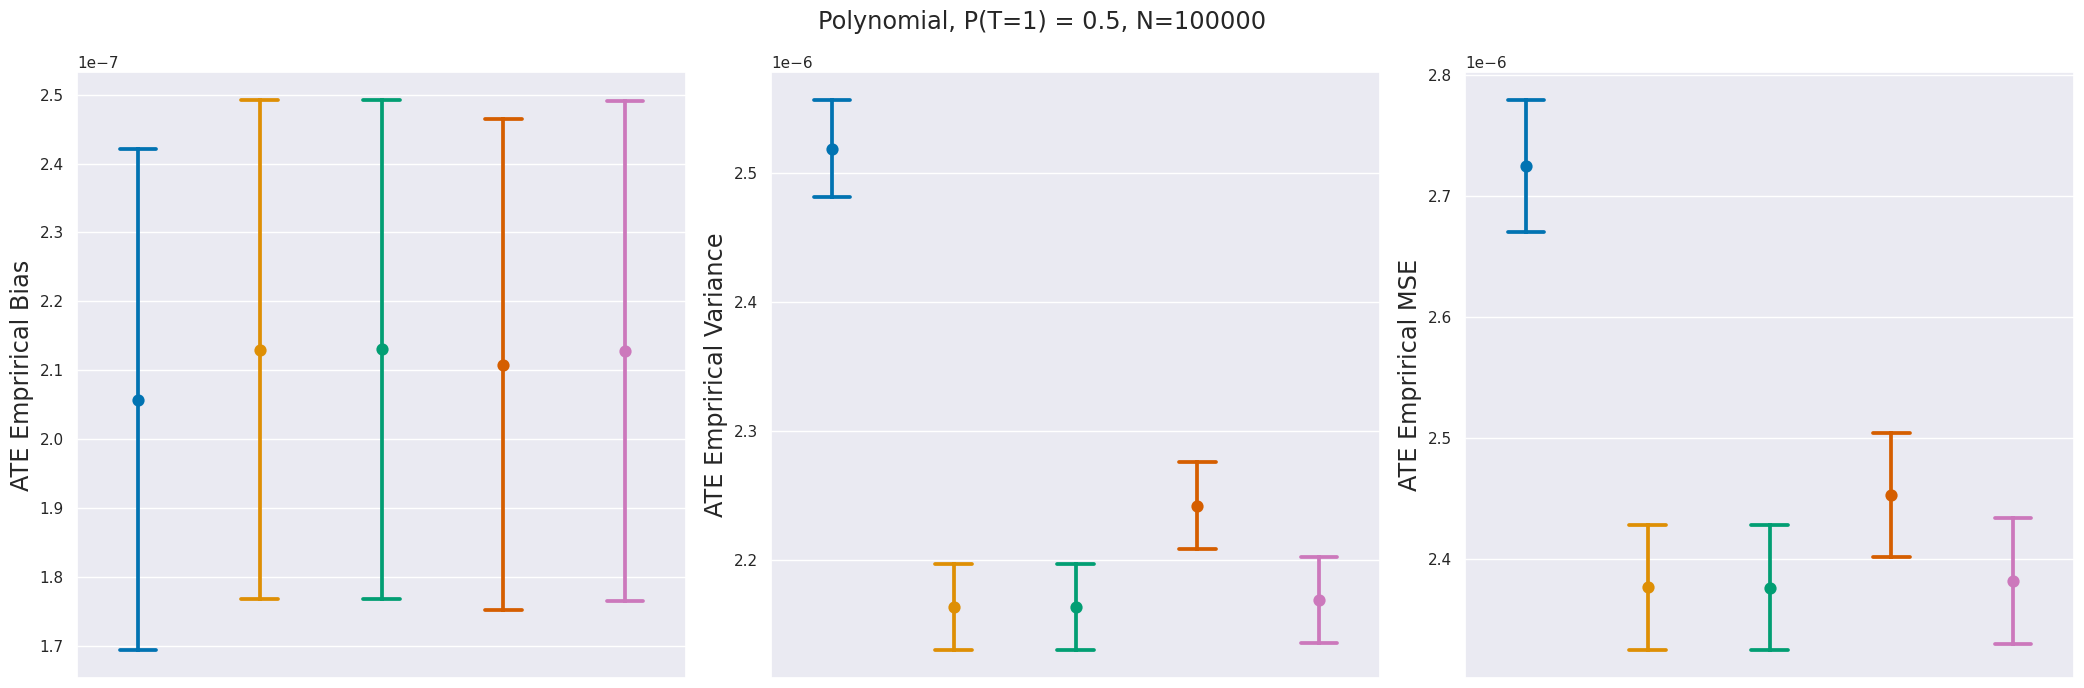

In [77]:
plot_bias(
    df_sem=df_sem,
    n=100000,
    balance=0.5,
    method="Polynomial",
)

## GP

In [45]:
base_dir = Path(f"experiments/ATE/Polynomial/")
df = pd.DataFrame()
df_sem = pd.DataFrame()
ns = [
    200,
    500,
    1000,
    2000,
]
balances = [
    0.5,
]
num_sims = 100
num_reps = 100
methods = [
    "OLS-Unadjusted", 
    "OLS-Adjusted",
    "OLS-Interact", 
    "GP-Adjusted",
    "GP-Interact",
]
for n in ns:
    for method in methods:
        for balance in balances:
            for seed in range(num_sims):
                exp_str = f"n={n}_balance={balance}_num-reps={num_reps}_seed={seed}"
                p = base_dir / f"{method}" / exp_str
                df = pd.concat([df, pd.read_csv(p / "results.csv")], axis=0)
                df_sem = pd.concat([df_sem, pd.read_csv(p / "results_sem.csv")], axis=0)

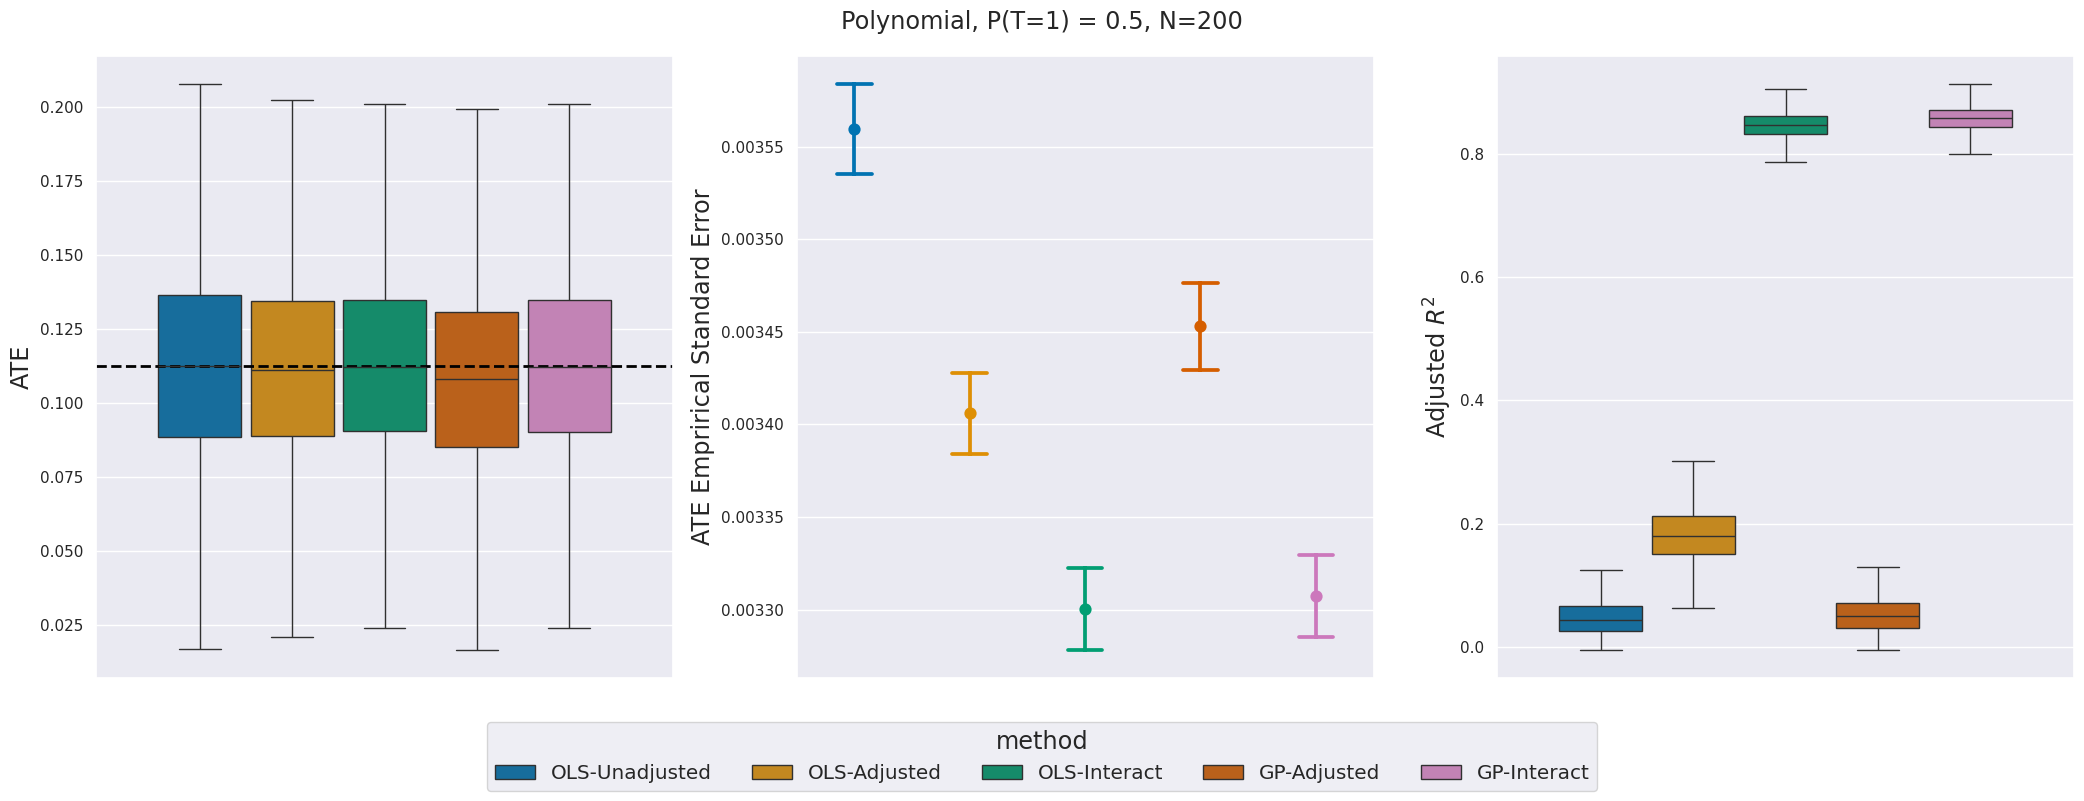

In [46]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=200,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

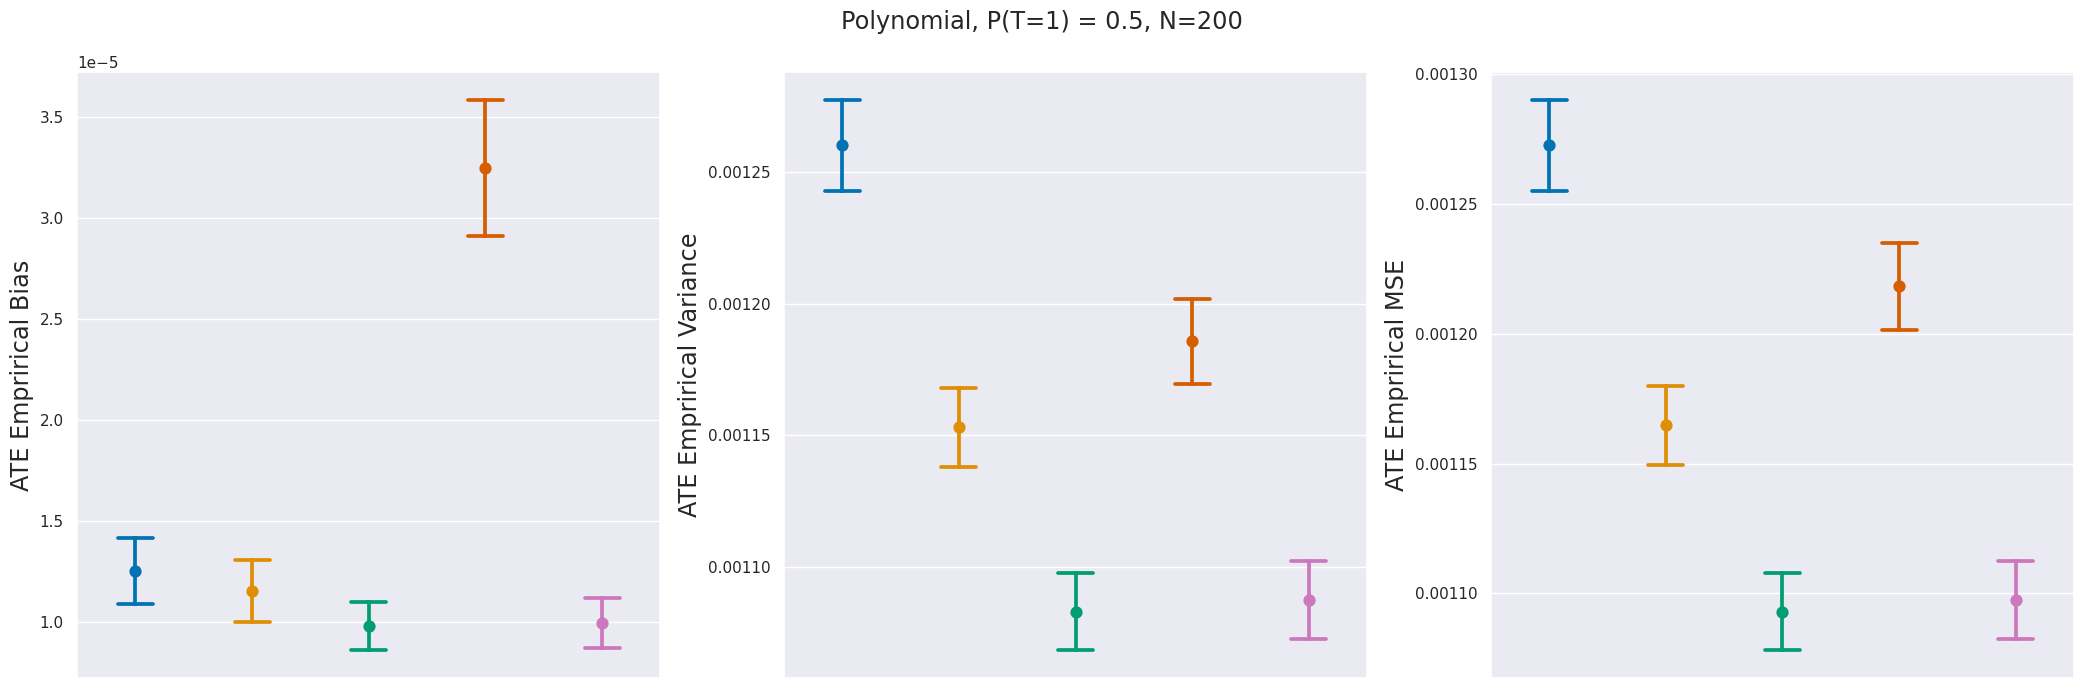

In [47]:
plot_bias(
    df_sem=df_sem,
    n=200,
    balance=0.5,
    method="Polynomial",
)

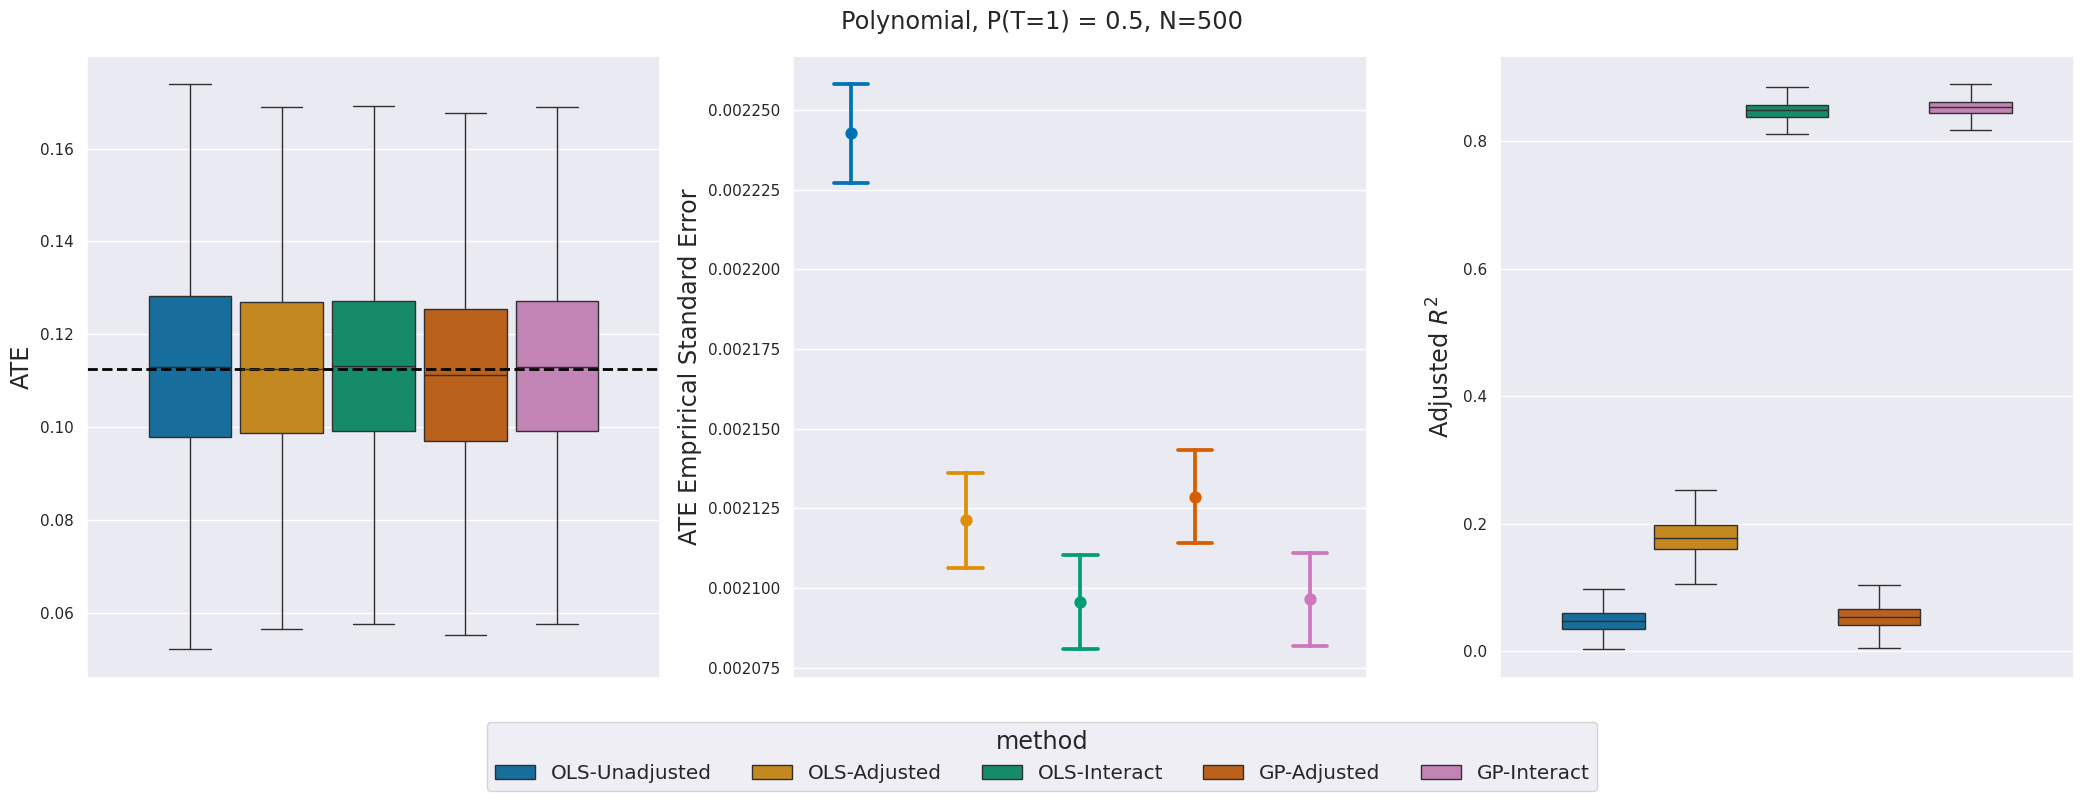

In [48]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=500,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

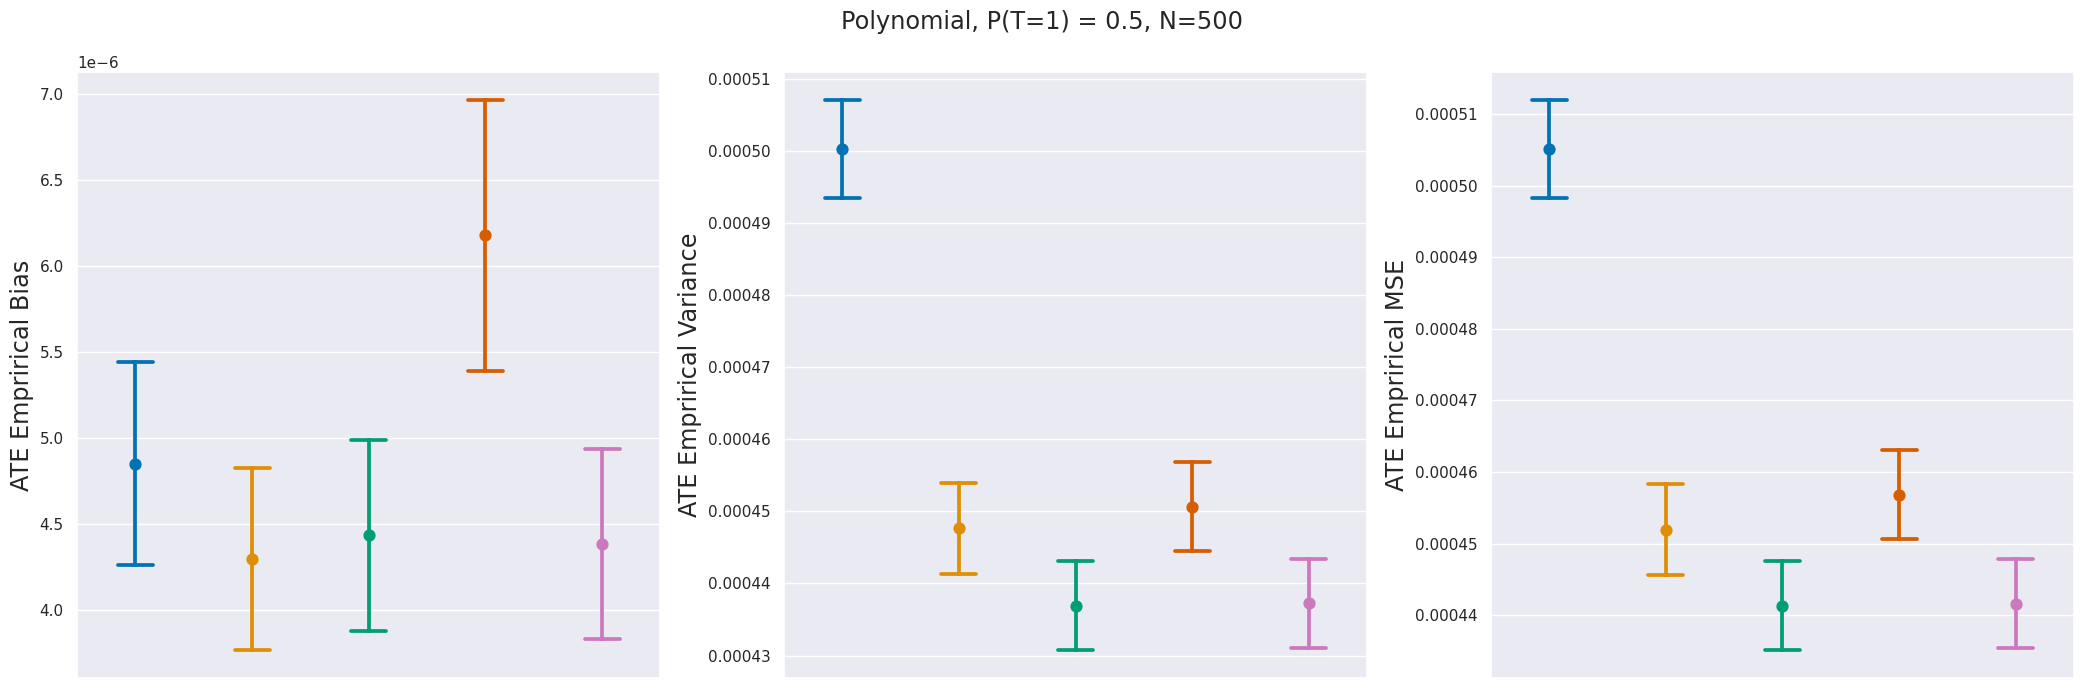

In [49]:
plot_bias(
    df_sem=df_sem,
    n=500,
    balance=0.5,
    method="Polynomial",
)

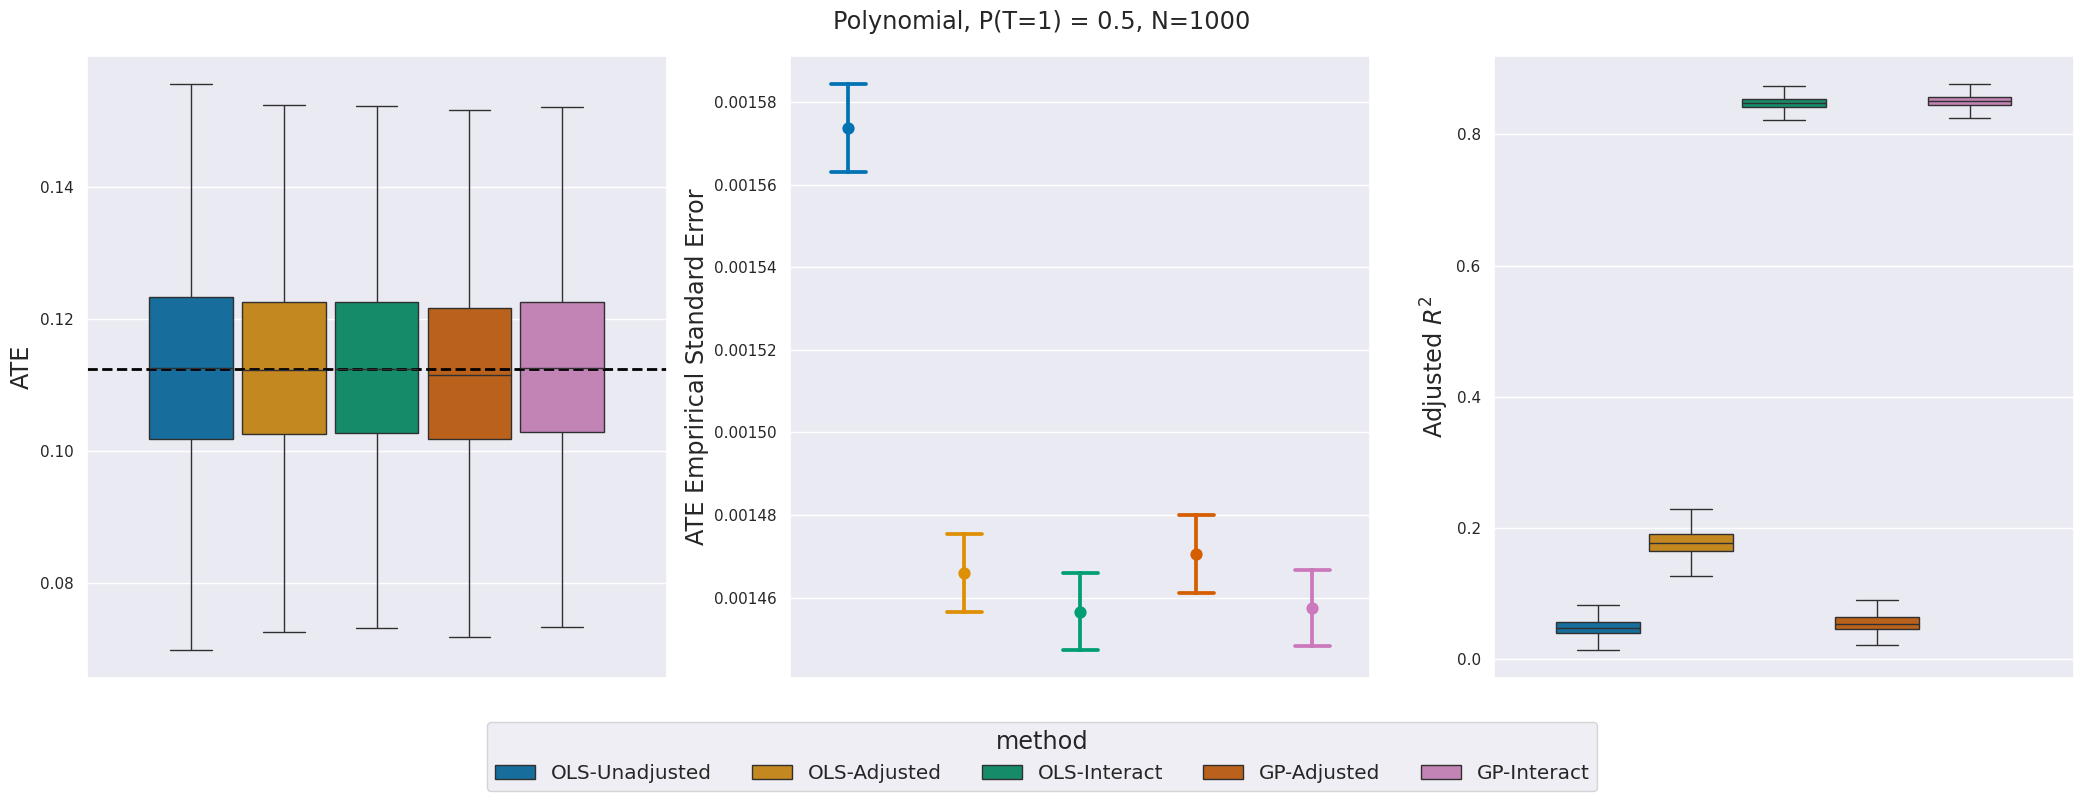

In [50]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=1000,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

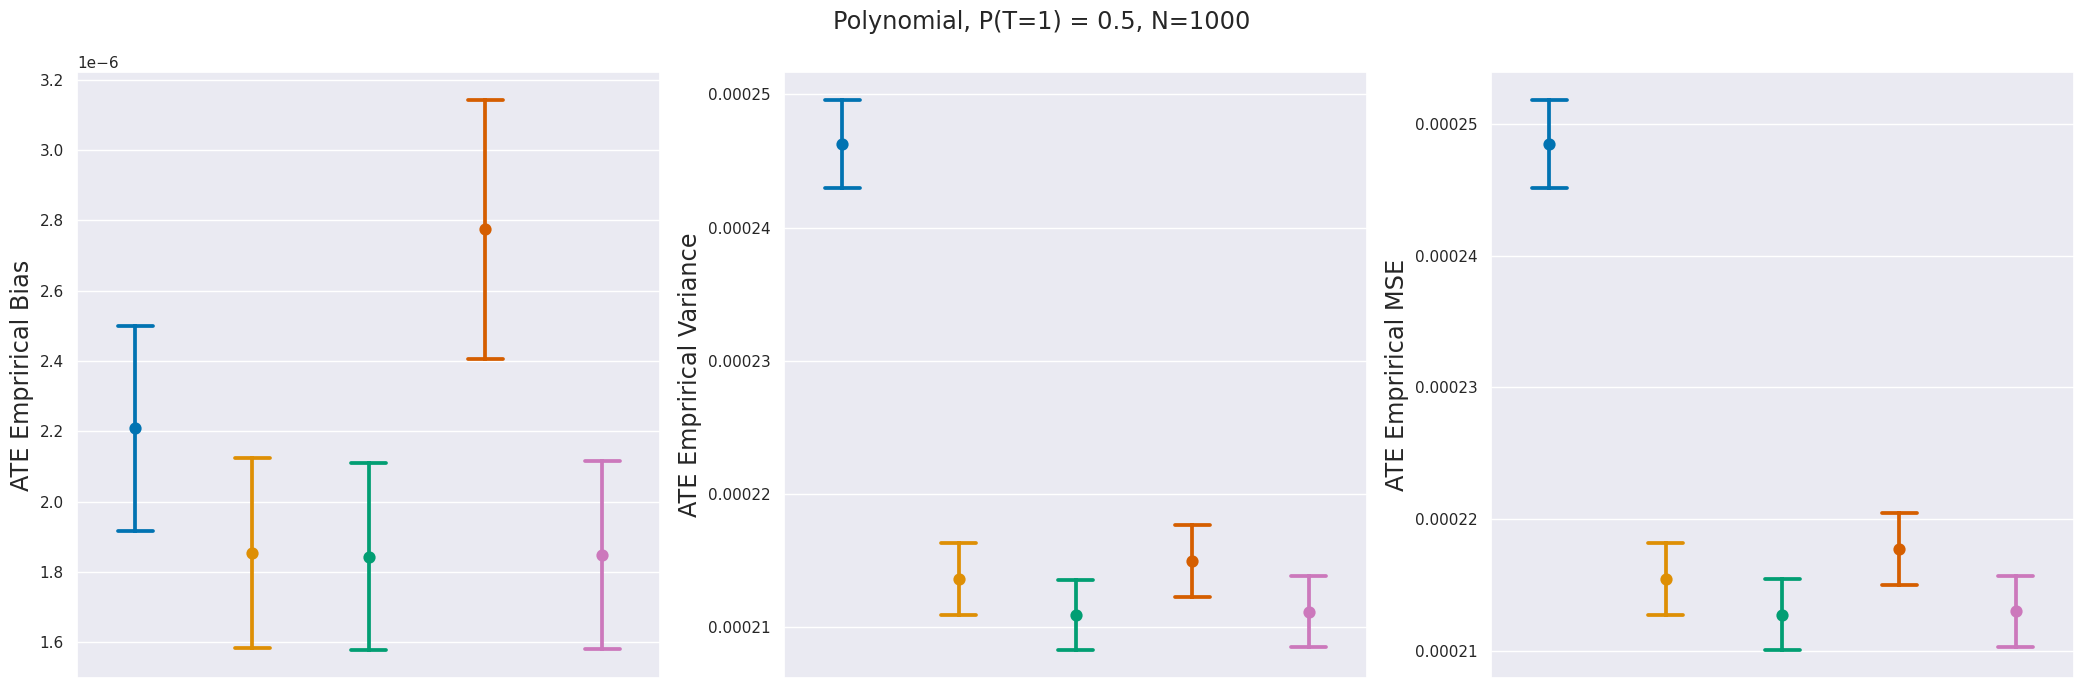

In [51]:
plot_bias(
    df_sem=df_sem,
    n=1000,
    balance=0.5,
    method="Polynomial",
)

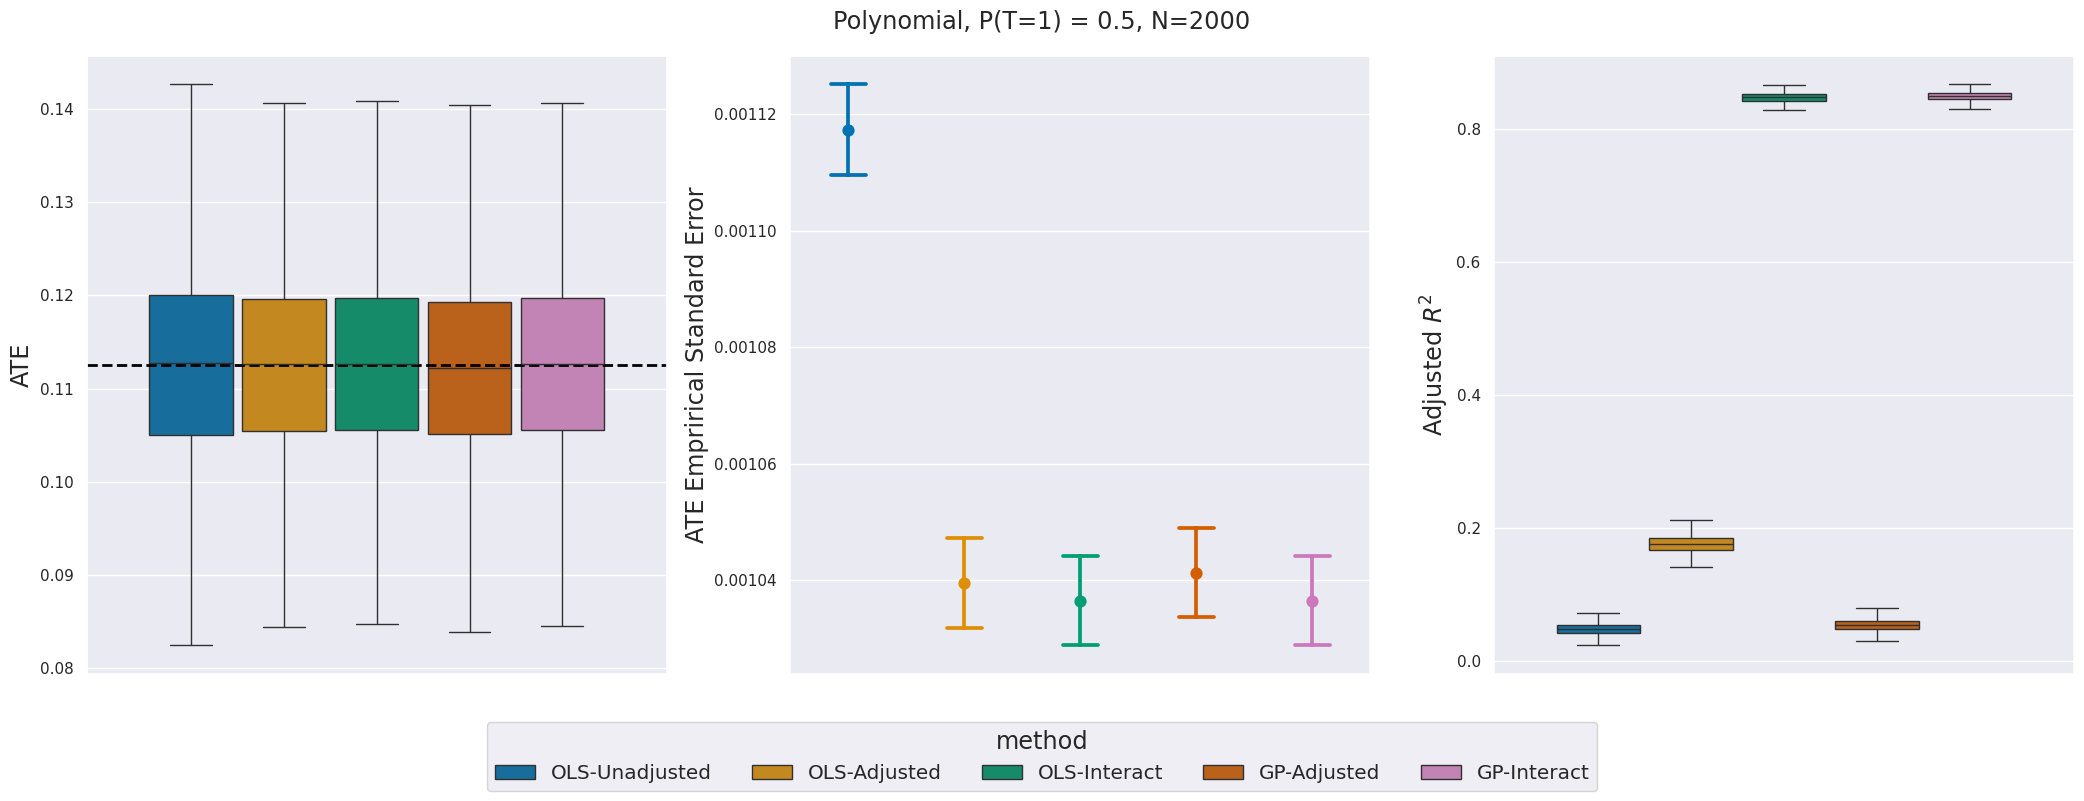

In [52]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=2000,
    balance=0.5,
    method="Polynomial",
    ate=ate_true,
)

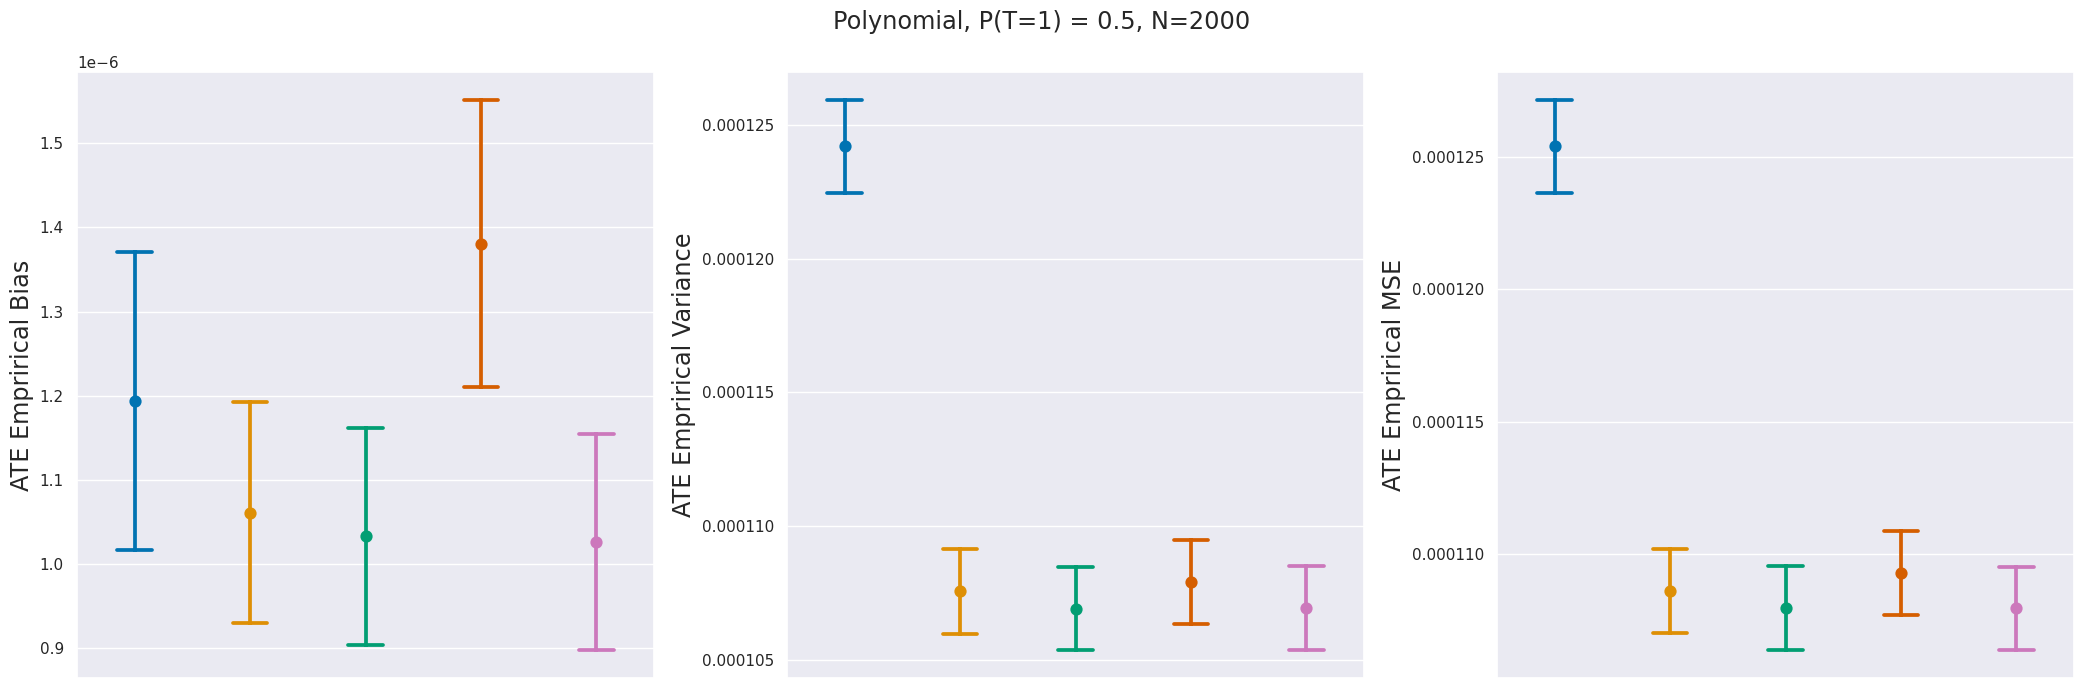

In [53]:
plot_bias(
    df_sem=df_sem,
    n=2000,
    balance=0.5,
    method="Polynomial",
)

# Funky

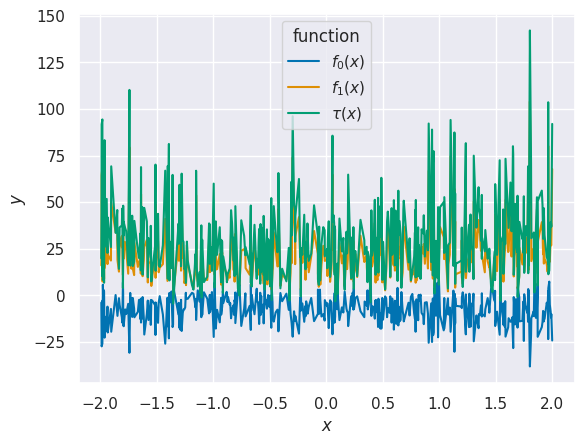

In [12]:
n = 1000000
ds = SinInteraction(
    n=n,
    d=8,
    slope=2,
    sigma=0.1,
    balance=0.5,
    degree=2,
    sparsity=0.5,
    beta_seed=1,
)
x, z, y = ds.sample(seed=seed)

df_0 = pd.DataFrame()
df_0[r"$x$"] = x[:500, 0]
df_0[r"$y$"] = ds.mu0[:500]
df_0["function"] = [r"$f_0(x)$"]* 500
df_1 = pd.DataFrame()
df_1[r"$x$"] = x[:500, 0]
df_1[r"$y$"] = ds.mu1[:500]
df_1["function"] = [r"$f_1(x)$"]* 500
df_tau = pd.DataFrame()
df_tau[r"$x$"] = x[:500, 0]
df_tau[r"$y$"] = ds.tau[:500]
df_tau["function"] = [r"$\tau(x)$"]* 500
df = pd.concat([df_0, df_1, df_tau], axis=0)

_ = sns.lineplot(
    df, 
    x=r"$x$", 
    y=r"$y$",
    hue="function",
)
ate_true = ds.tau.mean()

## GP

In [13]:
base_dir = Path(f"experiments/ATE/SinInteraction/")
df = pd.DataFrame()
df_sem = pd.DataFrame()
ns = [
    200,
    500,
    1000,
    2000,
]
balances = [
    0.5,
]
num_sims = 100
num_reps = 100
methods = [
    "OLS-Unadjusted", 
    "OLS-Adjusted",
    "OLS-Interact", 
    "GP-Adjusted",
    "GP-Interact",
    # "GRF-Adjusted",
    # "GRF-Interact", 
]
for n in ns:
    for method in methods:
        for balance in balances:
            for seed in range(num_sims):
                exp_str = f"n={n}_balance={balance}_num-reps={num_reps}_seed={seed}"
                p = base_dir / f"{method}" / exp_str
                df = pd.concat([df, pd.read_csv(p / "results.csv")], axis=0)
                df_sem = pd.concat([df_sem, pd.read_csv(p / "results_sem.csv")], axis=0)

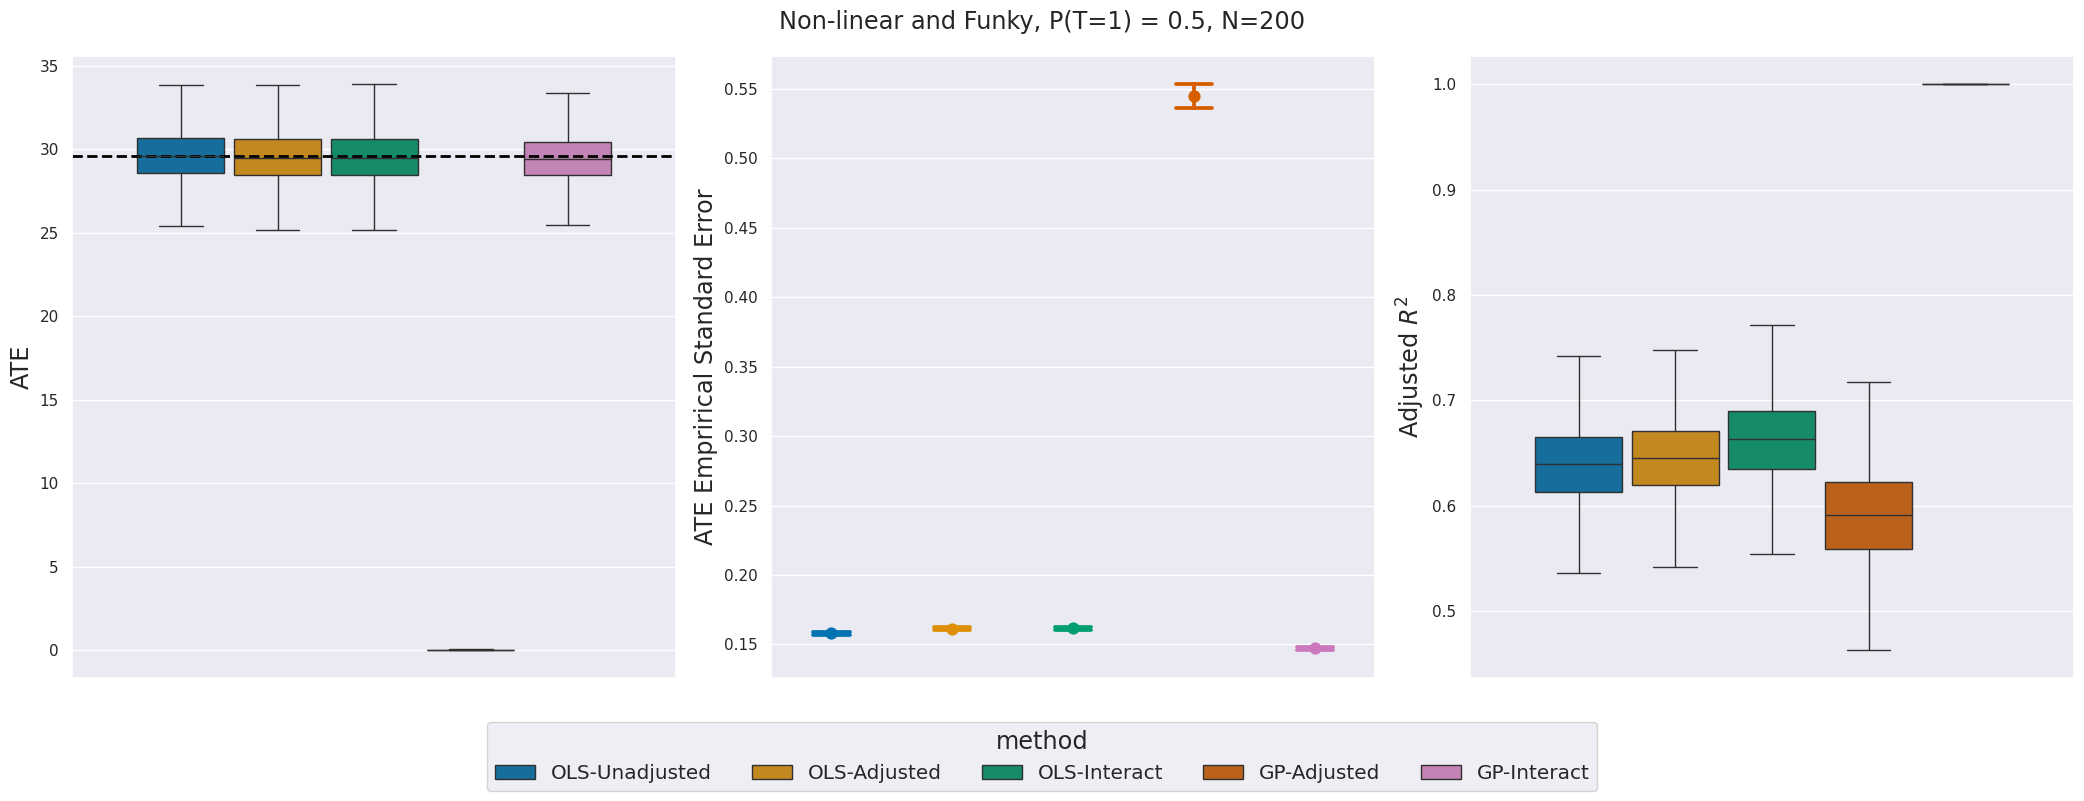

In [14]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=200,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

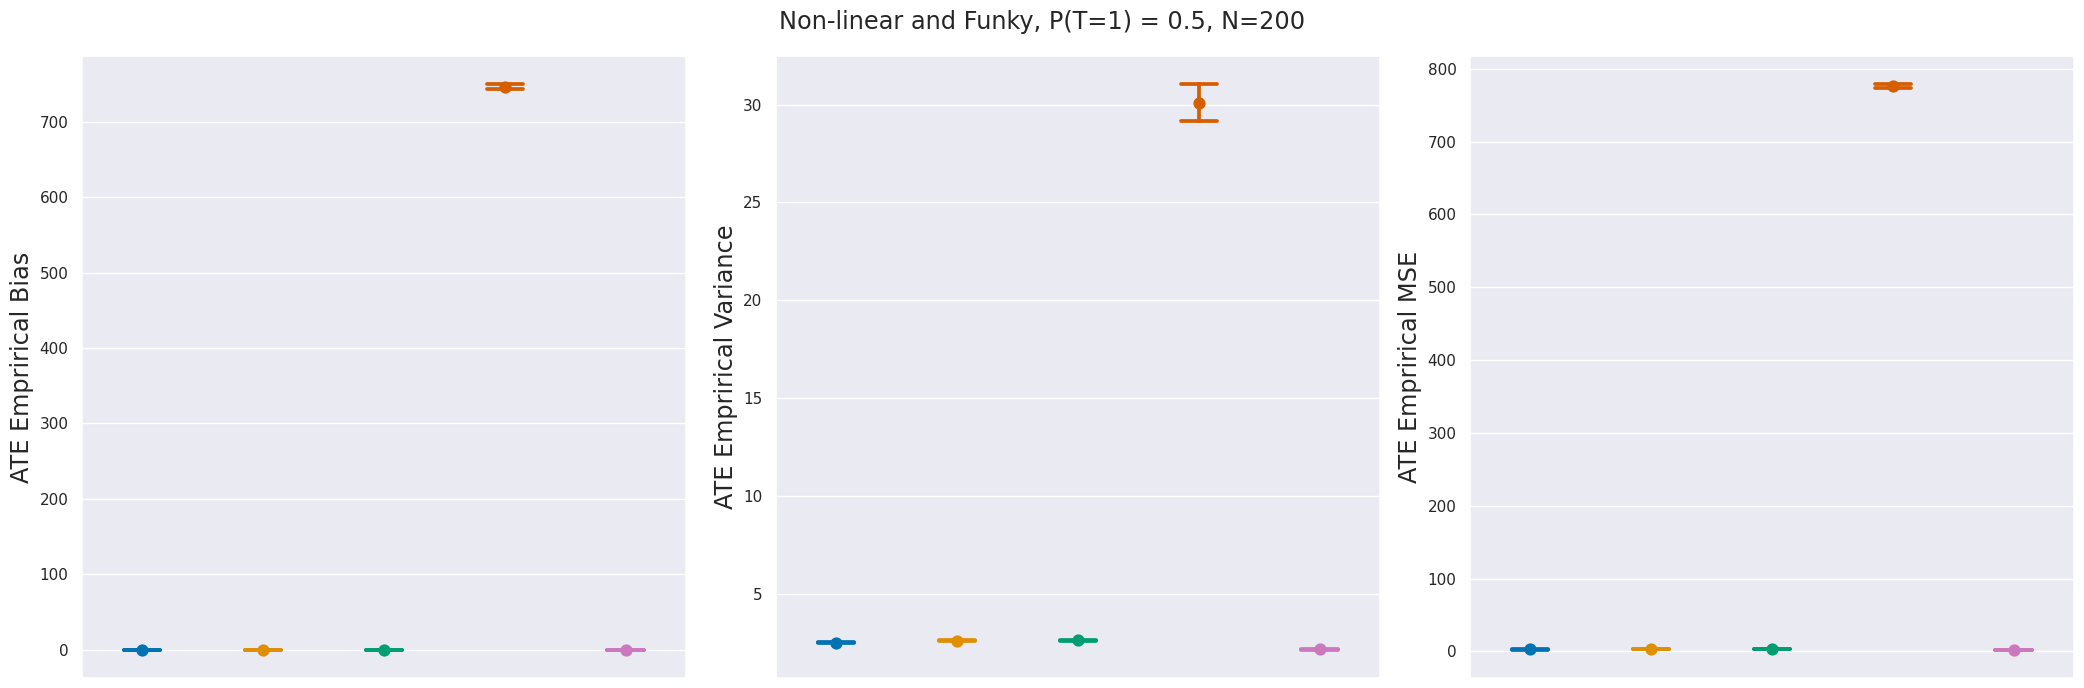

In [15]:
plot_bias(
    df_sem=df_sem,
    n=200,
    balance=0.5,
    method="Non-linear and Funky",
)

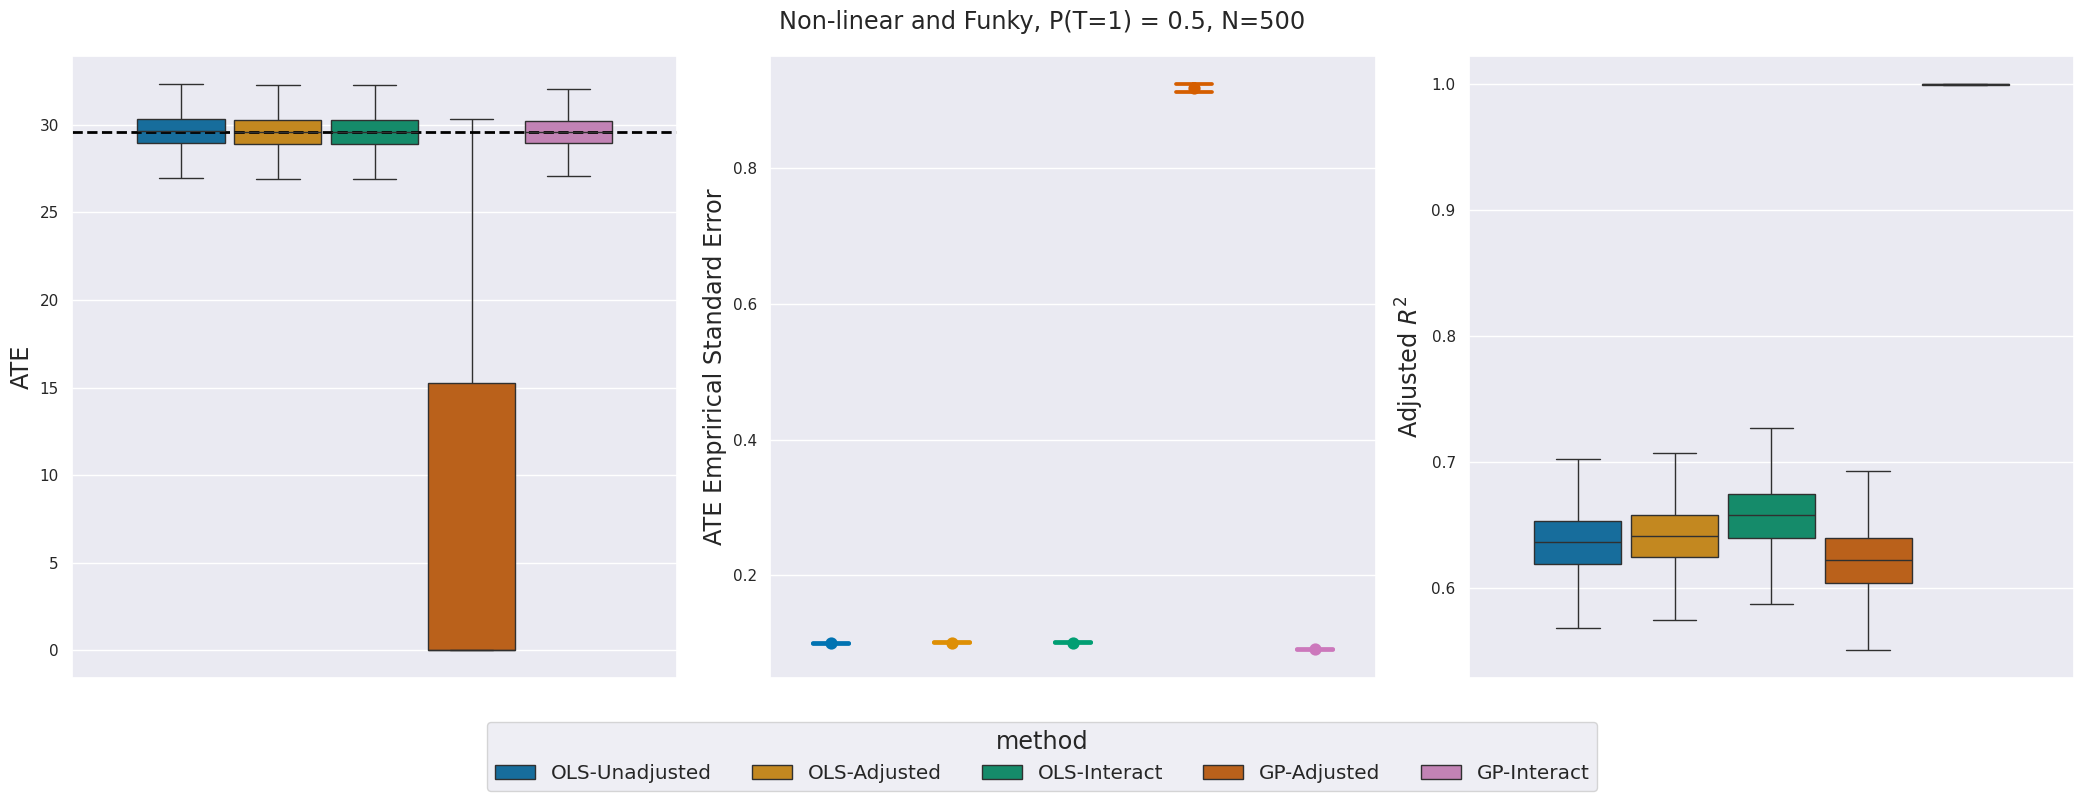

In [16]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=500,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

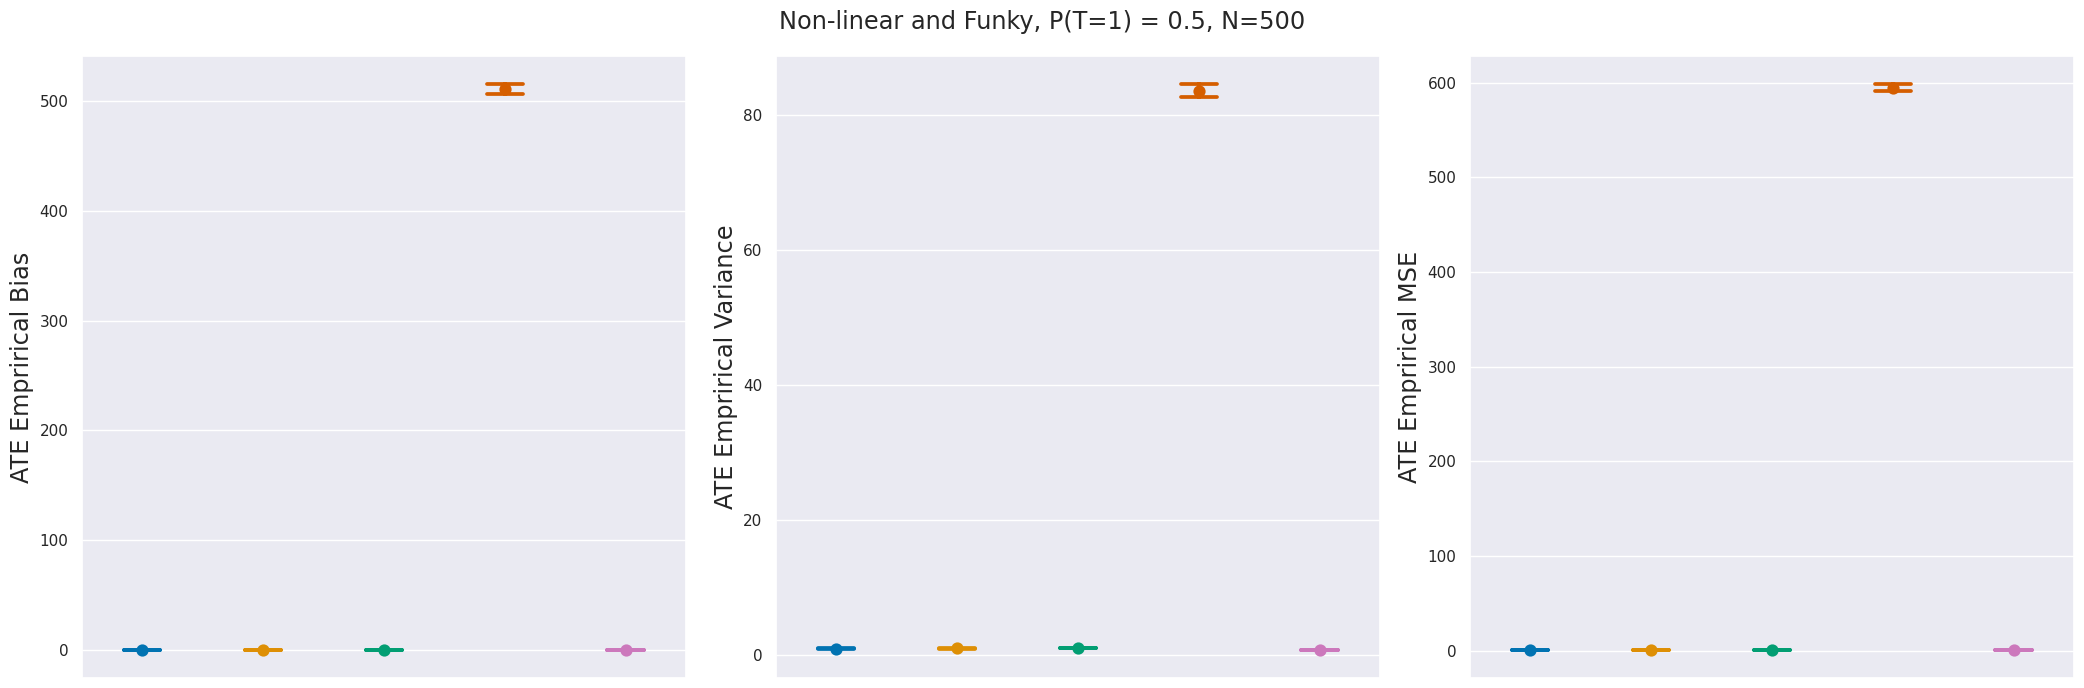

In [17]:
plot_bias(
    df_sem=df_sem,
    n=500,
    balance=0.5,
    method="Non-linear and Funky",
)

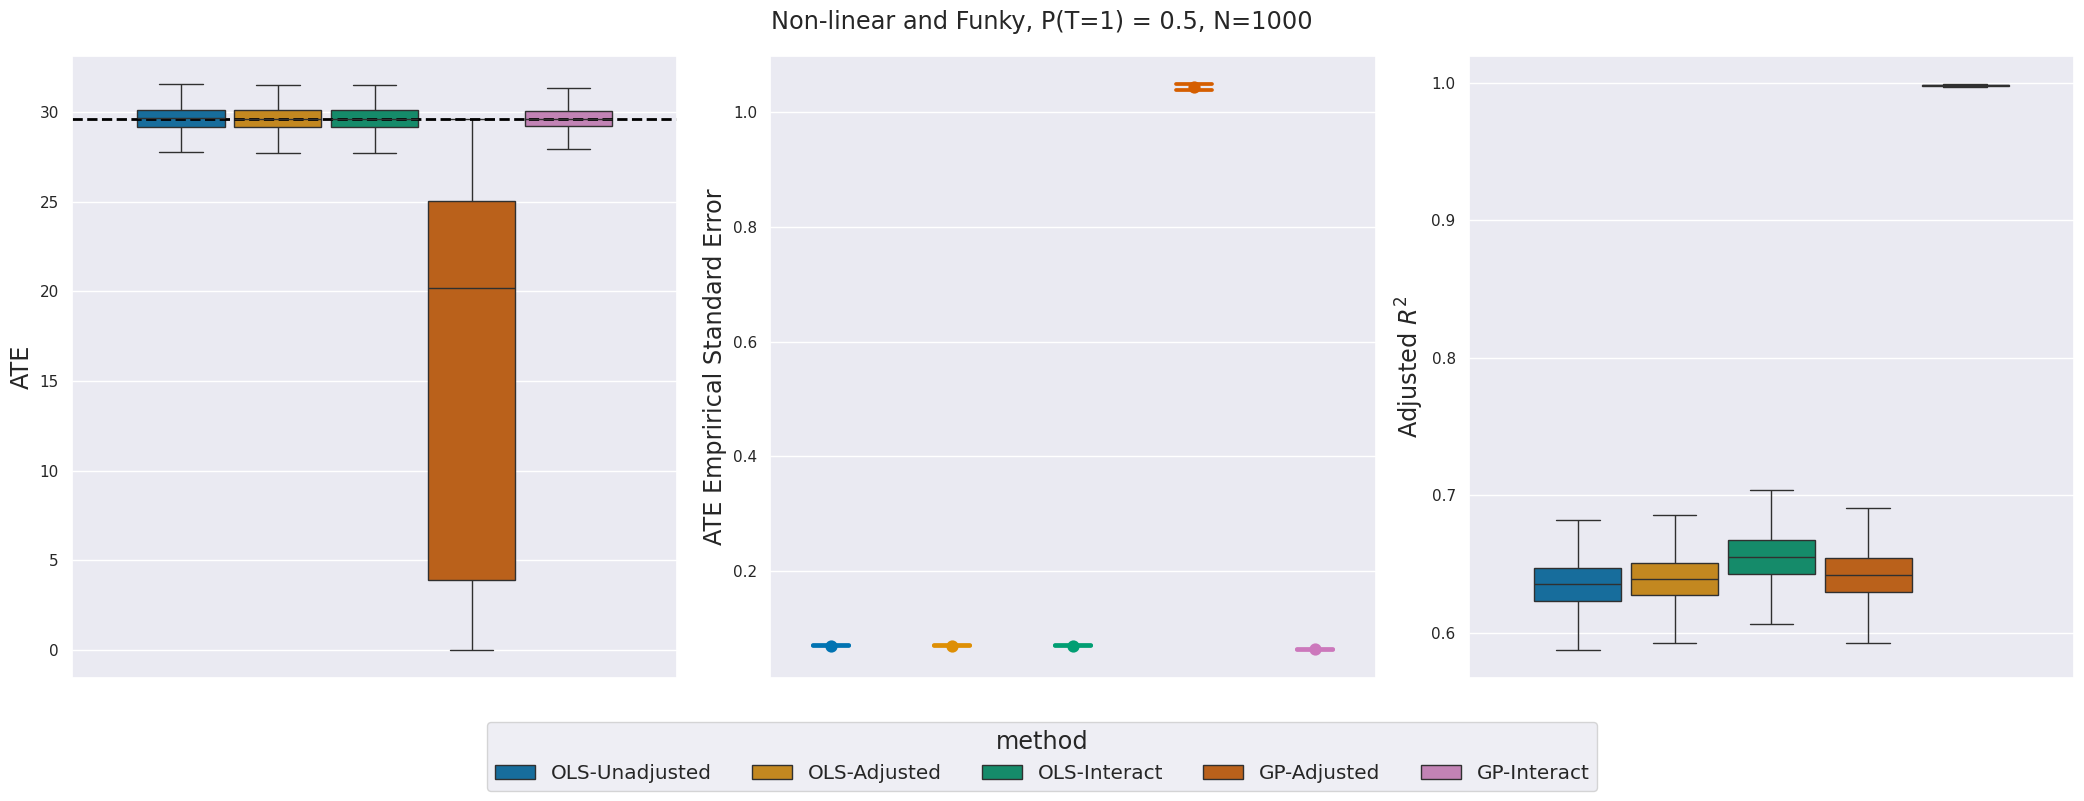

In [18]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=1000,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

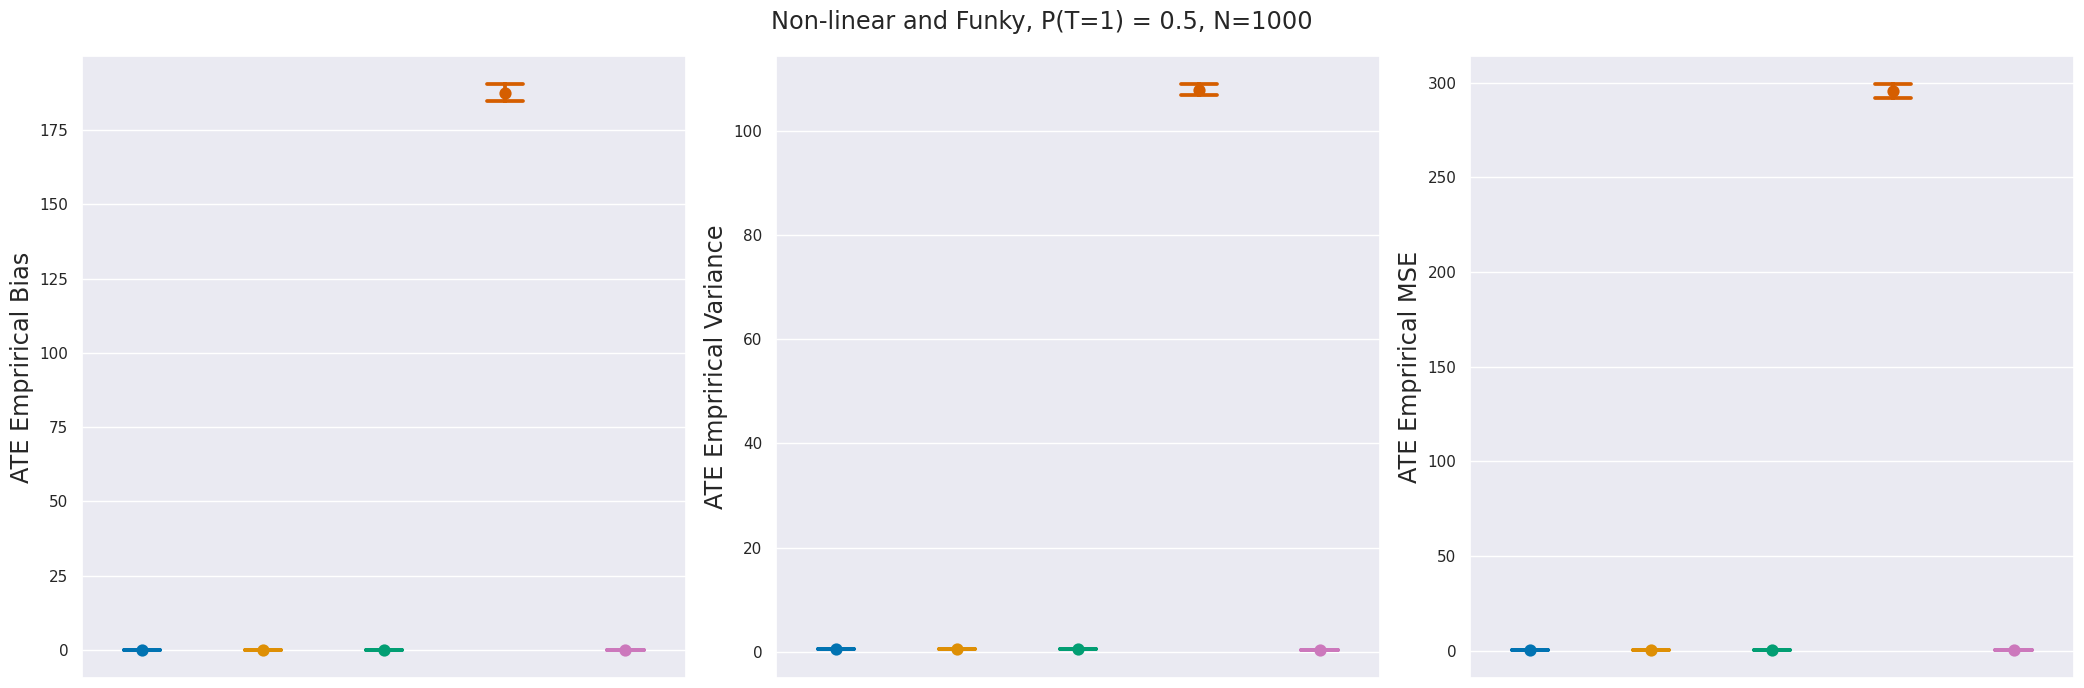

In [19]:
plot_bias(
    df_sem=df_sem,
    n=1000,
    balance=0.5,
    method="Non-linear and Funky",
)

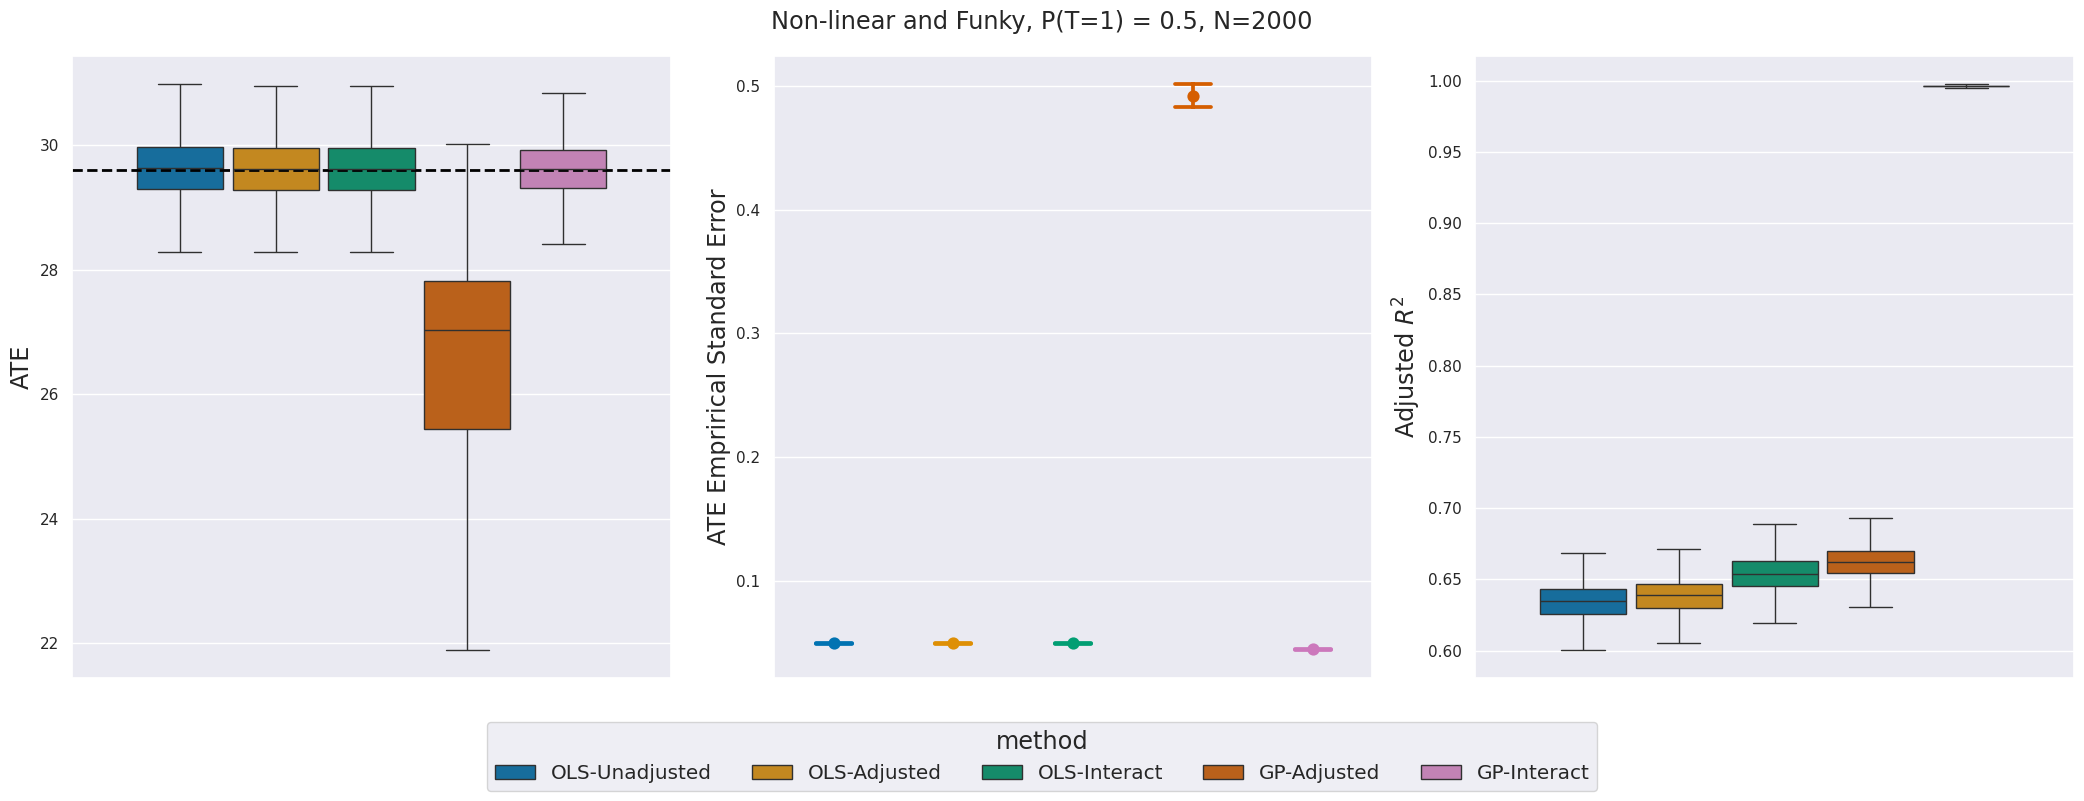

In [20]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=2000,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

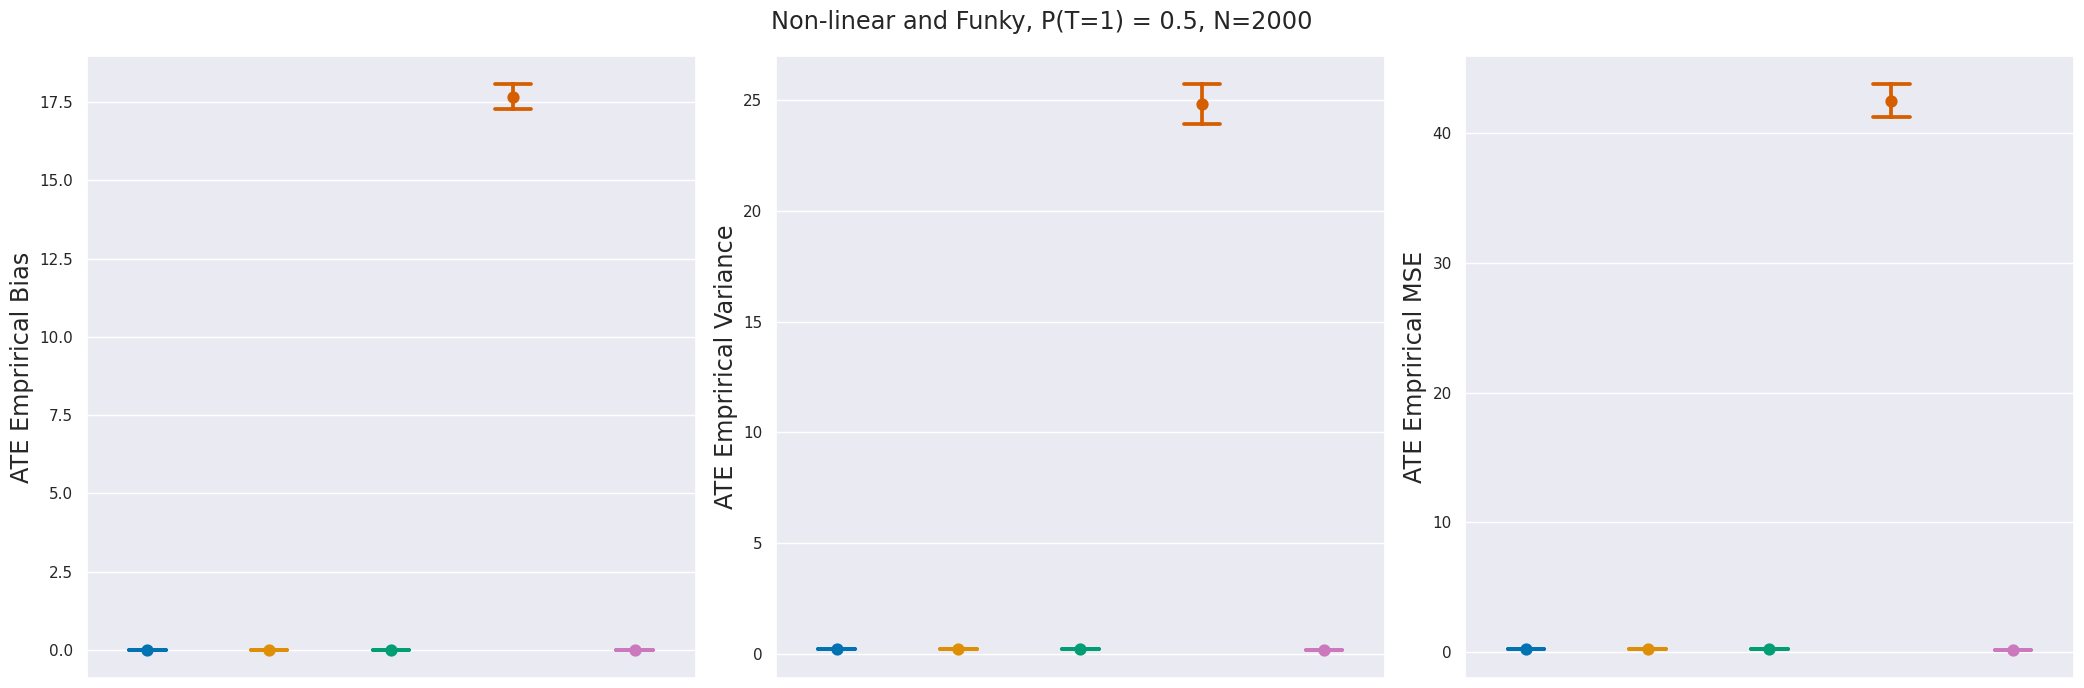

In [21]:
plot_bias(
    df_sem=df_sem,
    n=2000,
    balance=0.5,
    method="Non-linear and Funky",
)

## GRF

In [22]:
base_dir = Path(f"experiments/ATE/SinInteraction/")
df = pd.DataFrame()
df_sem = pd.DataFrame()
ns = [
    200,
    500,
    1000,
    10000,
    100000,
]
balances = [
    0.5,
]
num_sims = 100
num_reps = 100
methods = [
    "OLS-Unadjusted", 
    "OLS-Adjusted",
    "OLS-Interact", 
    "GRF-Adjusted",
    "GRF-Interact", 
]
for n in ns:
    for method in methods:
        for balance in balances:
            for seed in range(num_sims):
                exp_str = f"n={n}_balance={balance}_num-reps={num_reps}_seed={seed}"
                p = base_dir / f"{method}" / exp_str
                df = pd.concat([df, pd.read_csv(p / "results.csv")], axis=0)
                df_sem = pd.concat([df_sem, pd.read_csv(p / "results_sem.csv")], axis=0)

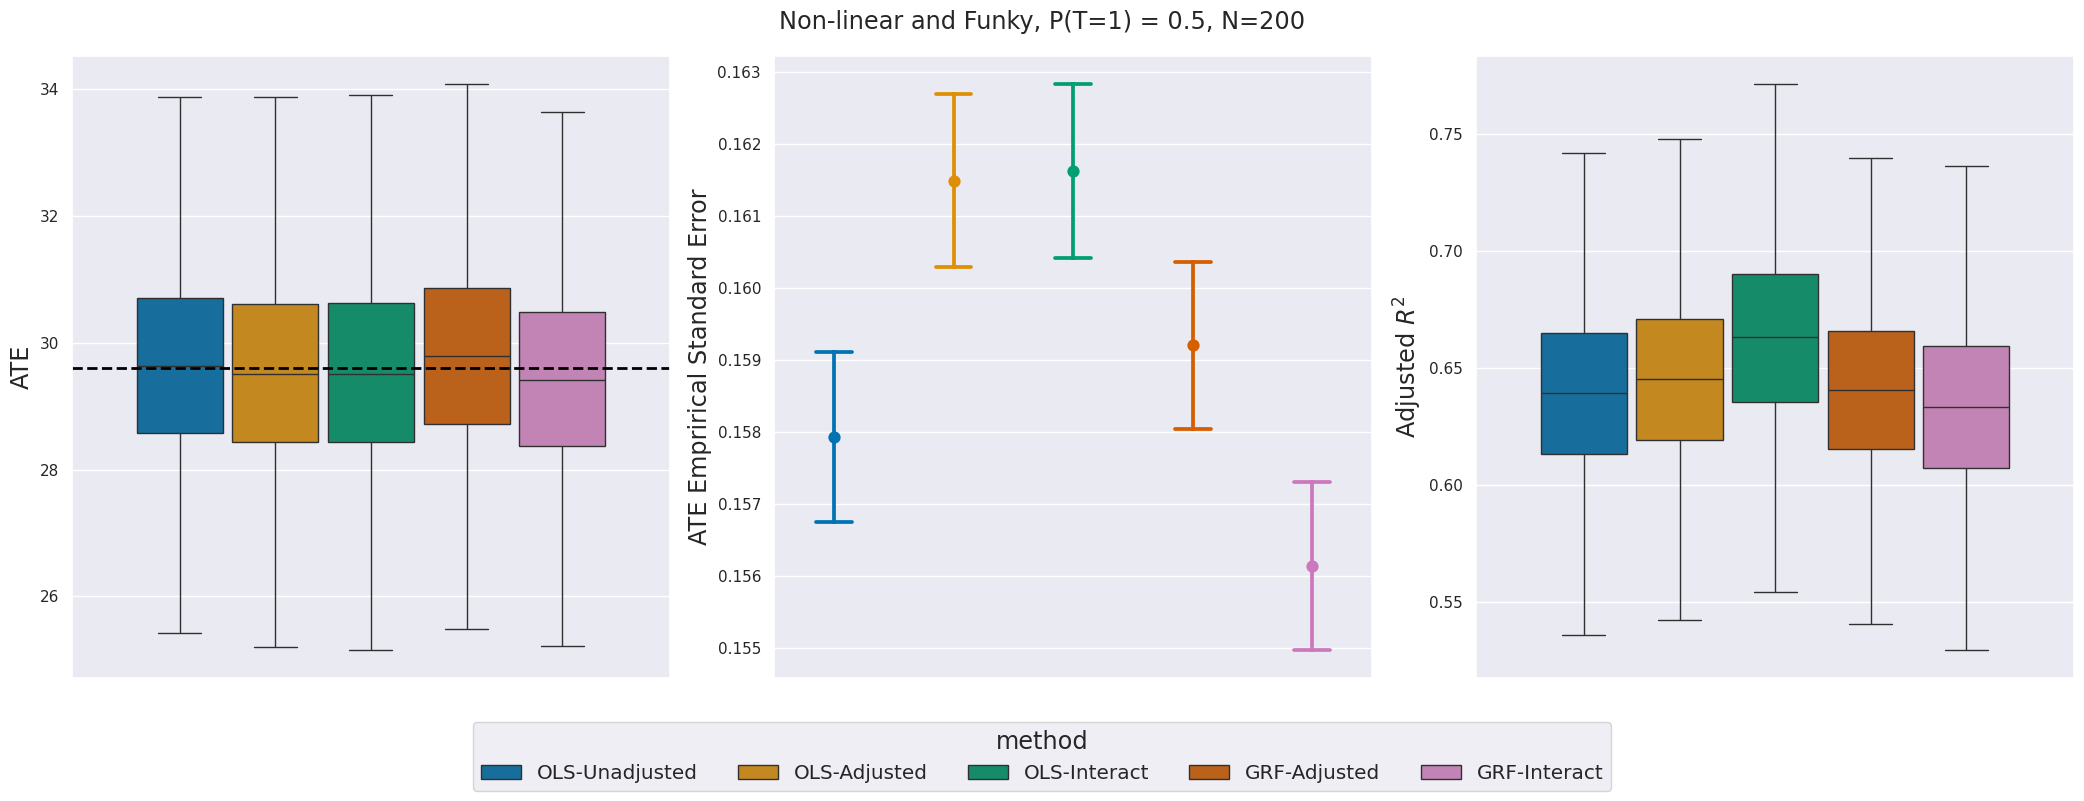

In [23]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=200,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

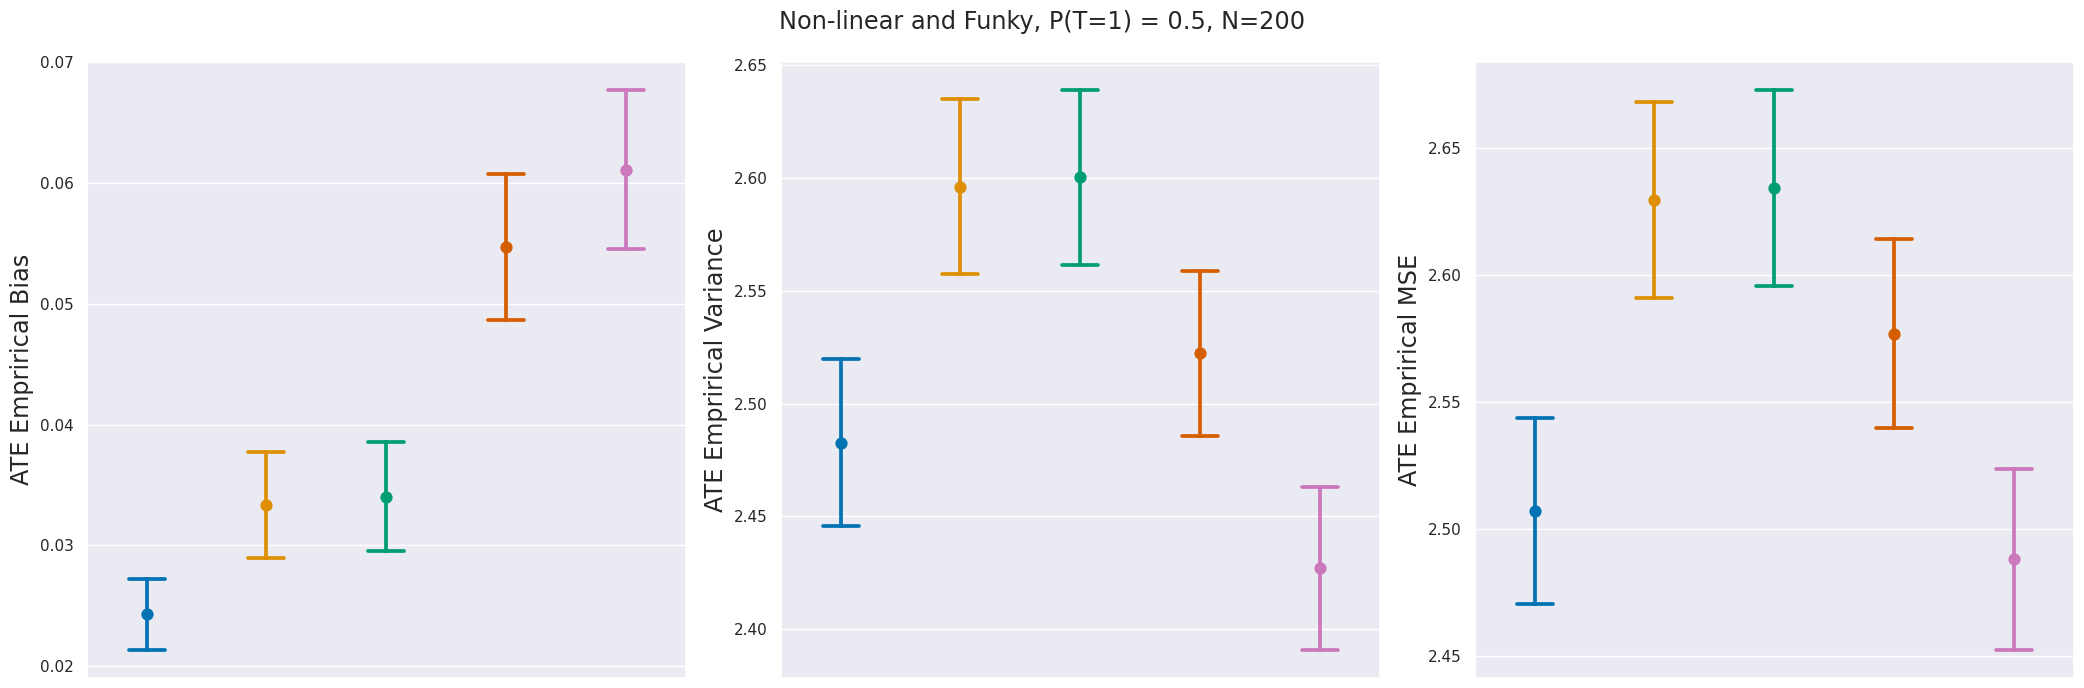

In [24]:
plot_bias(
    df_sem=df_sem,
    n=200,
    balance=0.5,
    method="Non-linear and Funky",
)

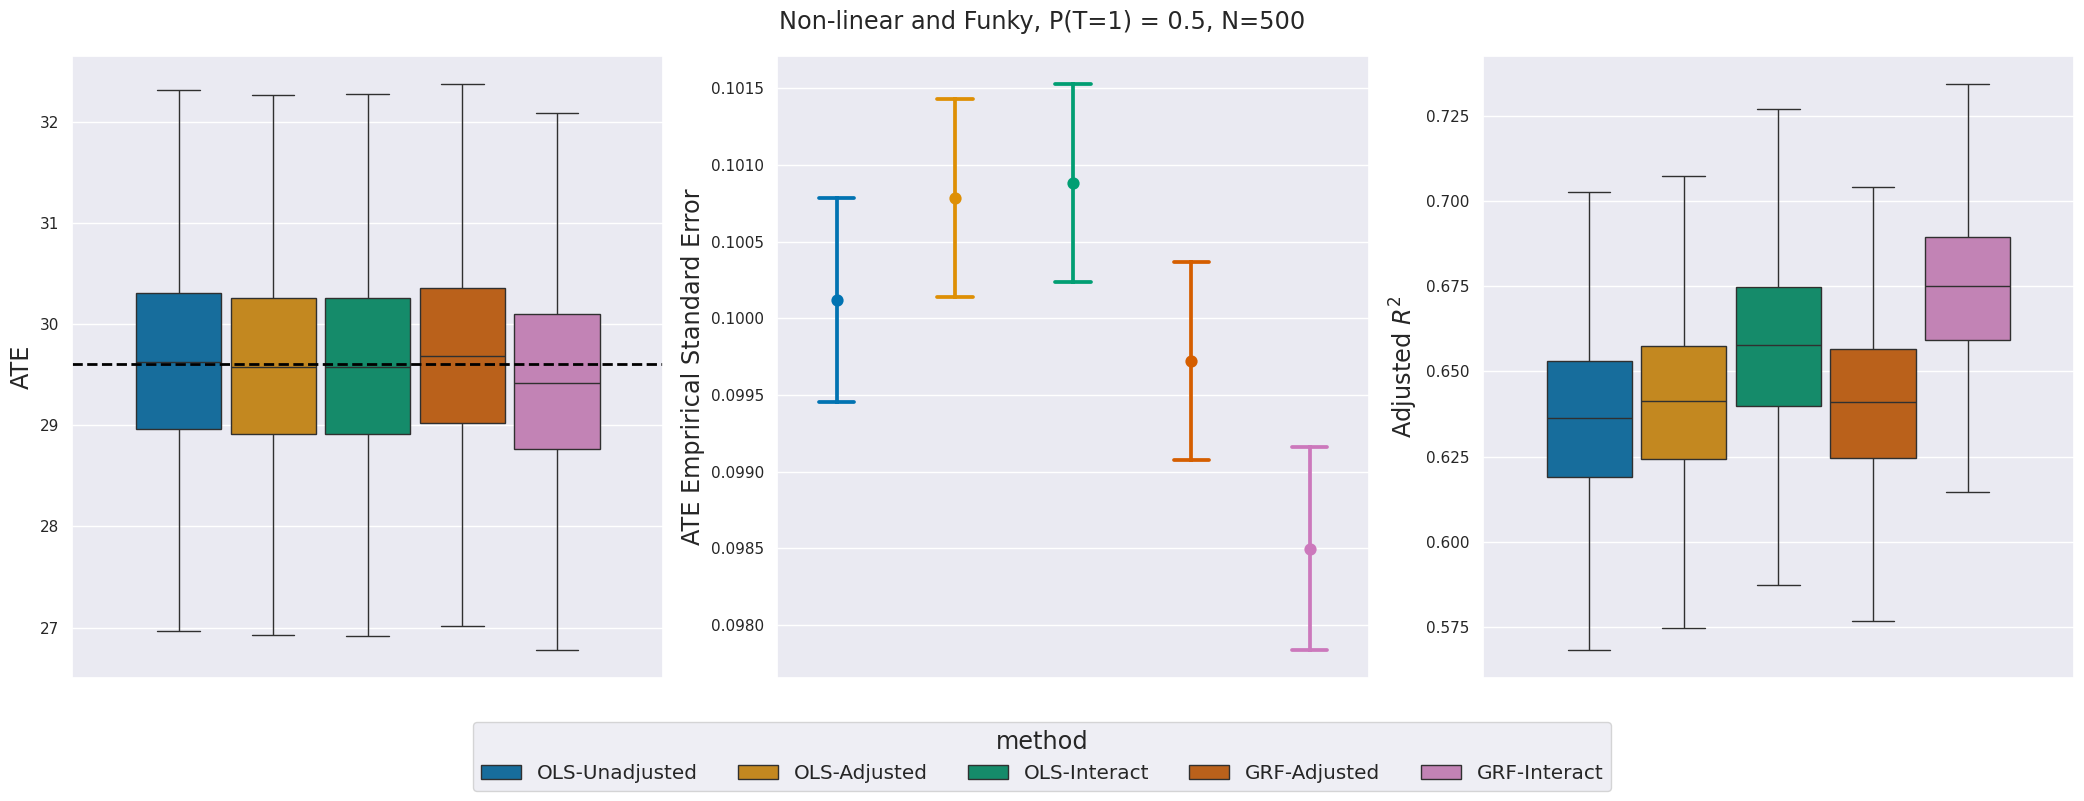

In [25]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=500,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

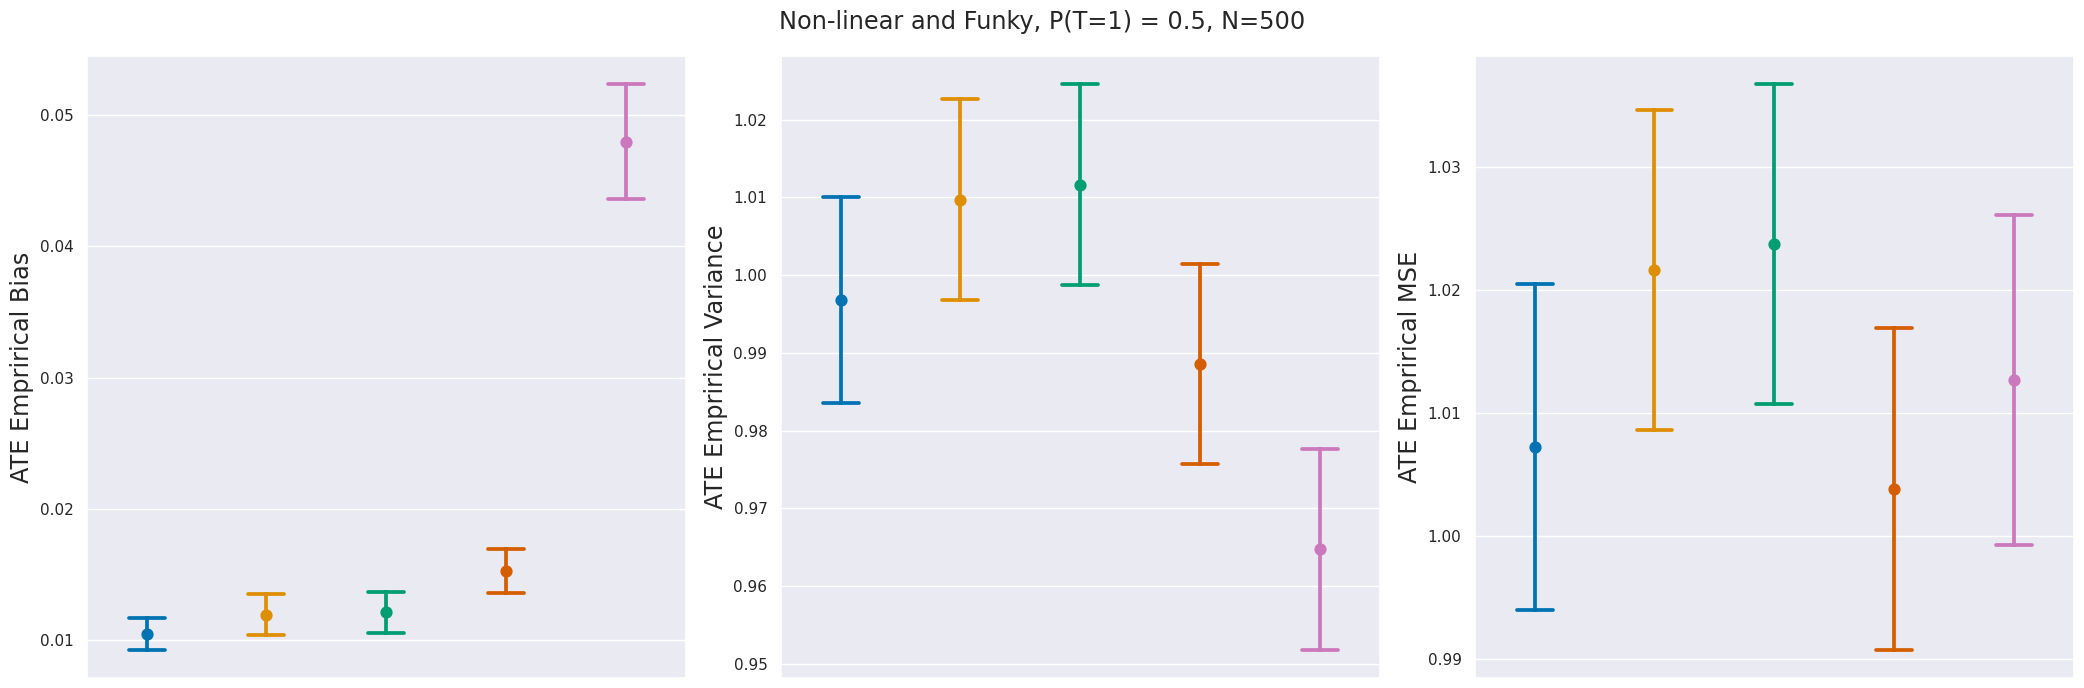

In [26]:
plot_bias(
    df_sem=df_sem,
    n=500,
    balance=0.5,
    method="Non-linear and Funky",
)

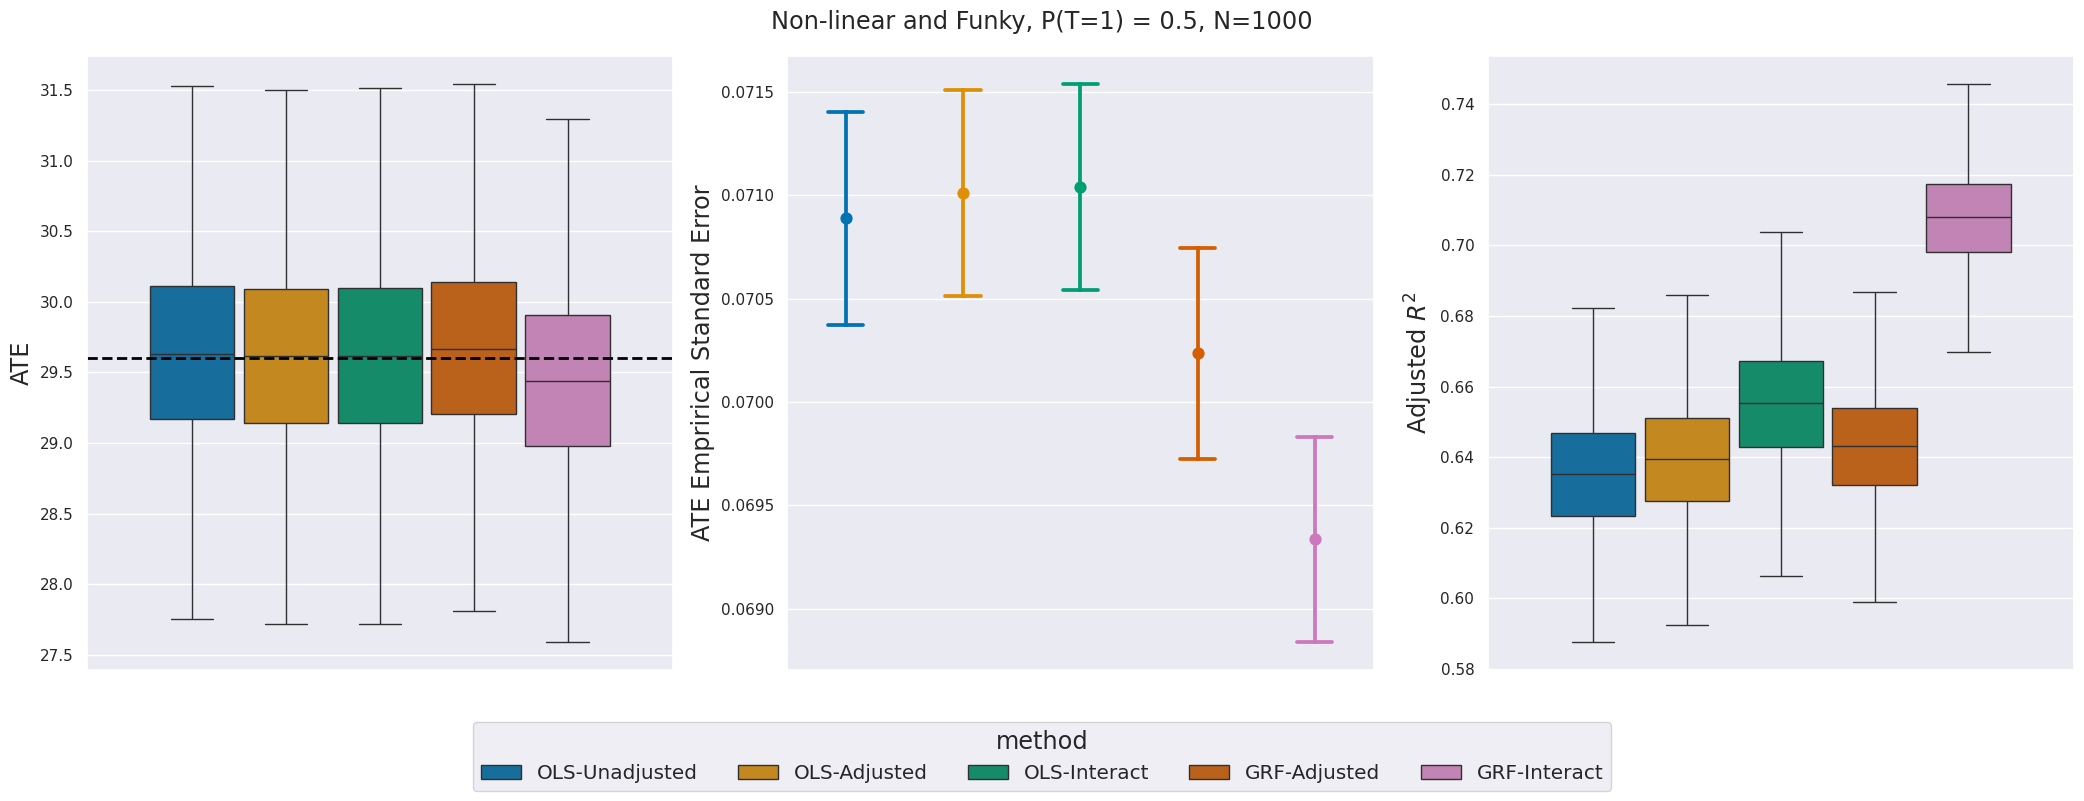

In [27]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=1000,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

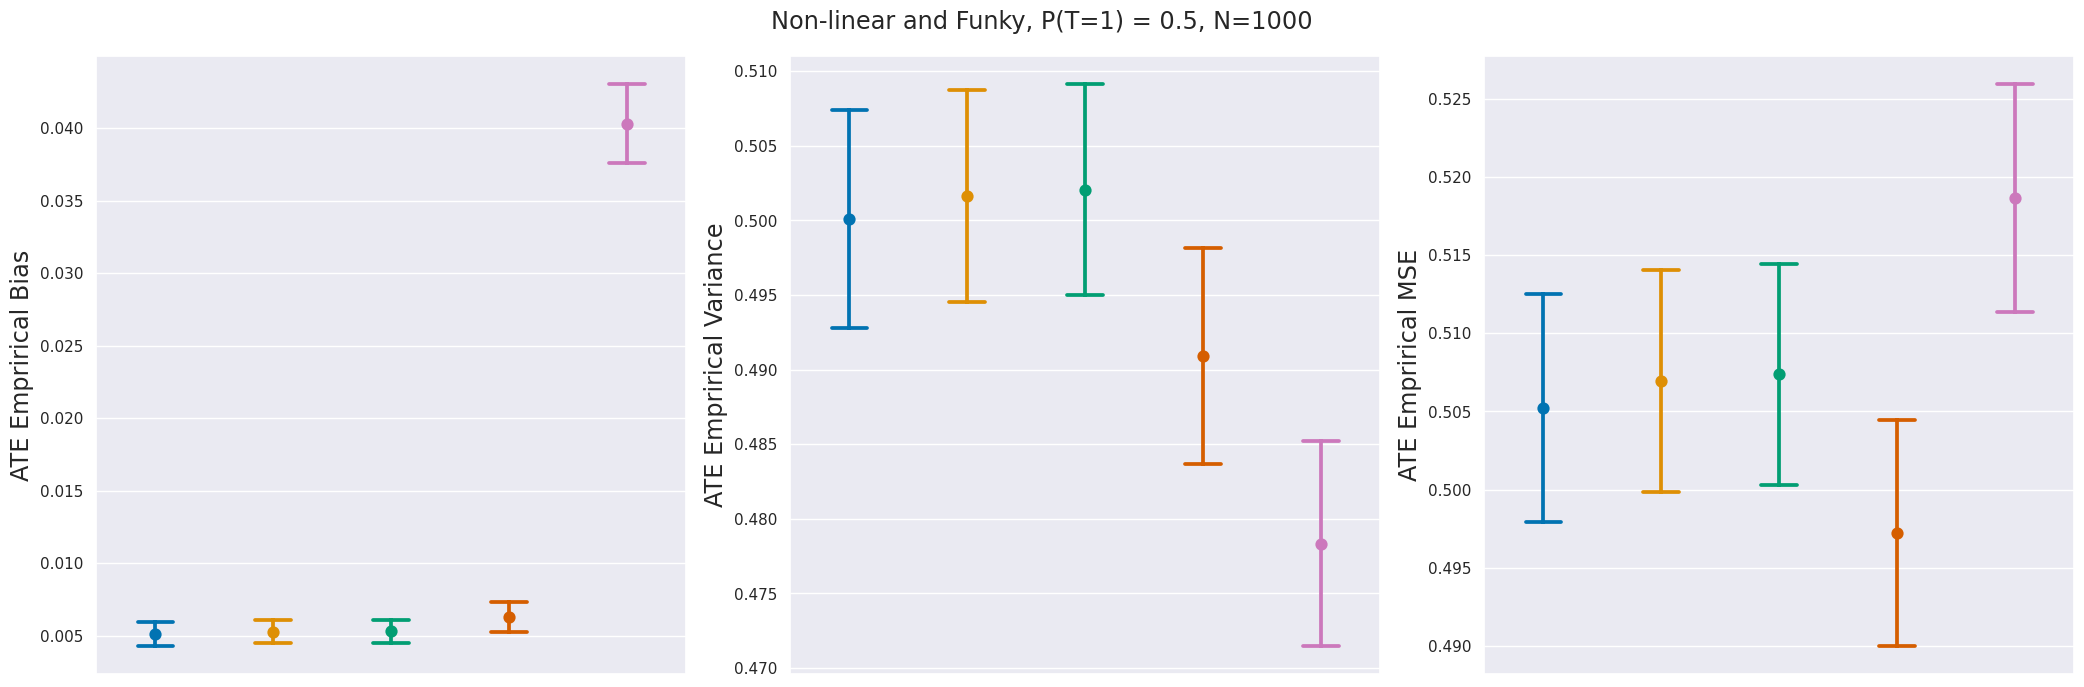

In [28]:
plot_bias(
    df_sem=df_sem,
    n=1000,
    balance=0.5,
    method="Non-linear and Funky",
)

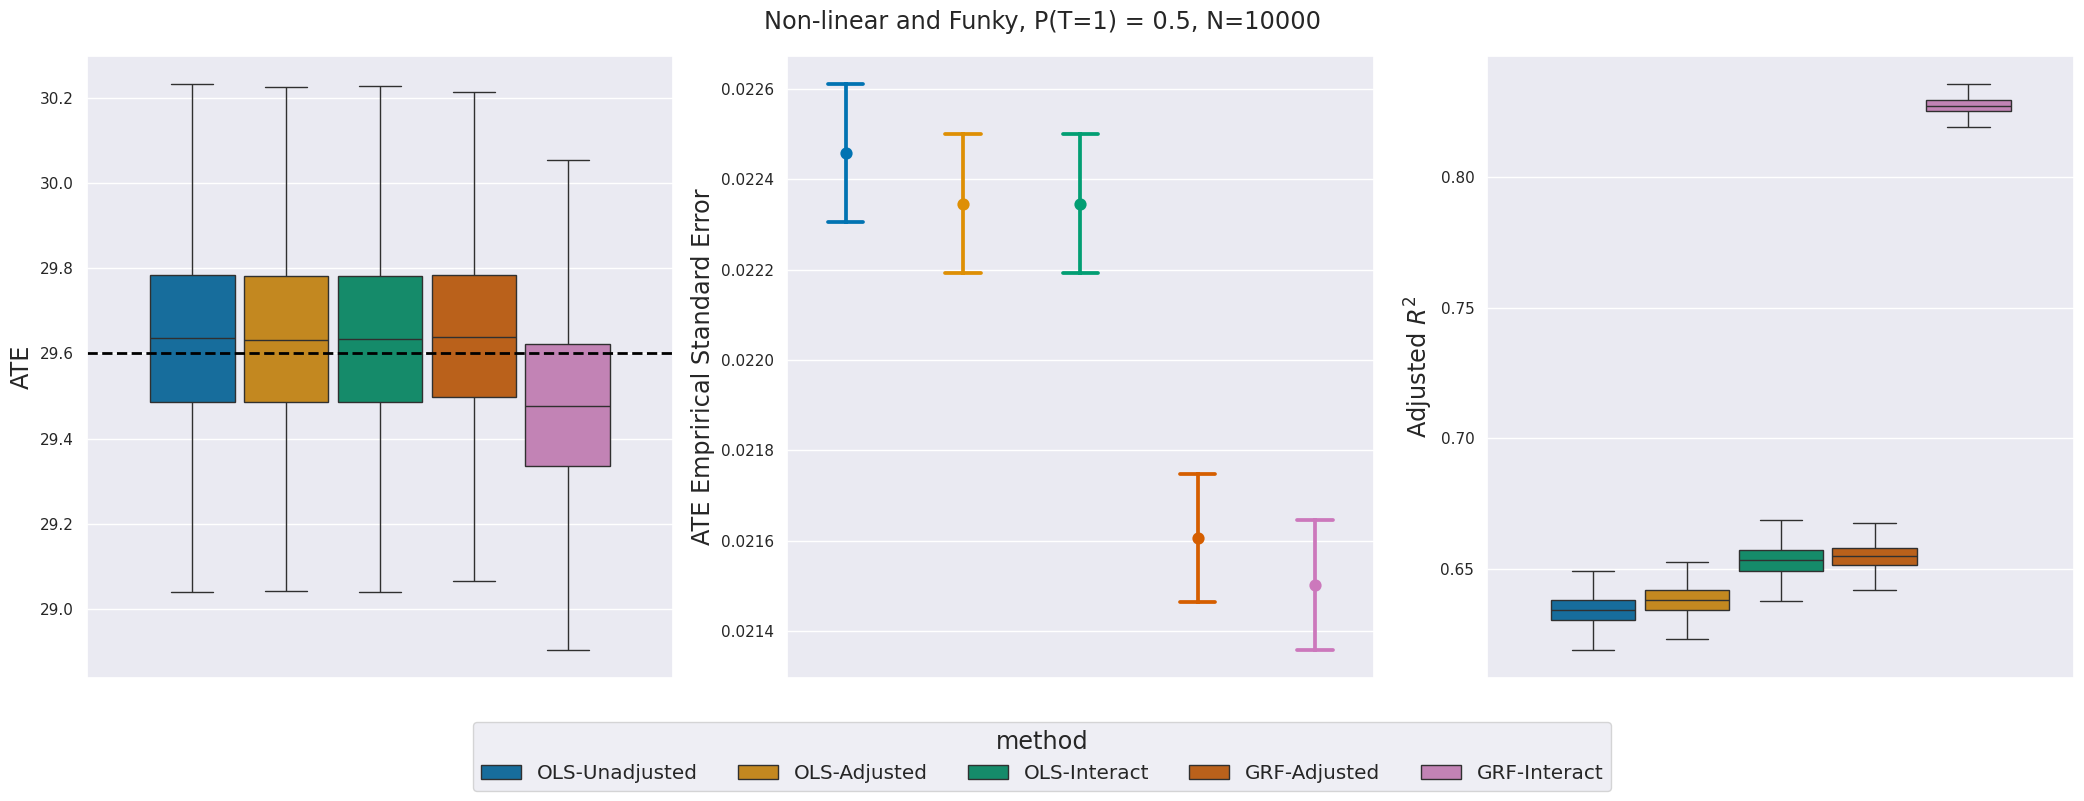

In [29]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=10000,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

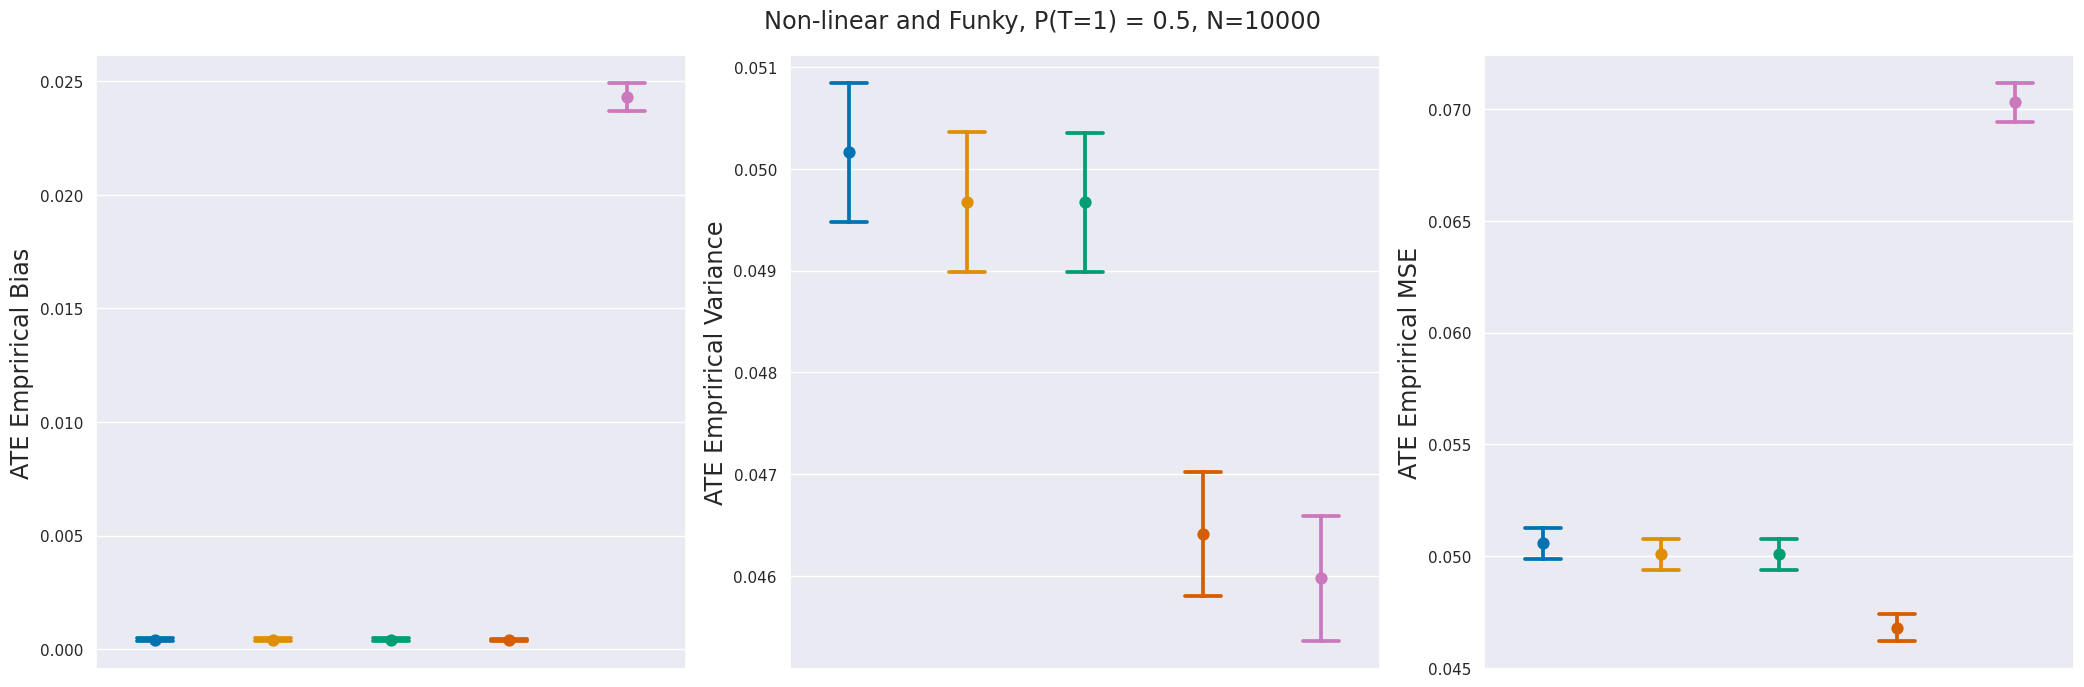

In [30]:
plot_bias(
    df_sem=df_sem,
    n=10000,
    balance=0.5,
    method="Non-linear and Funky",
)

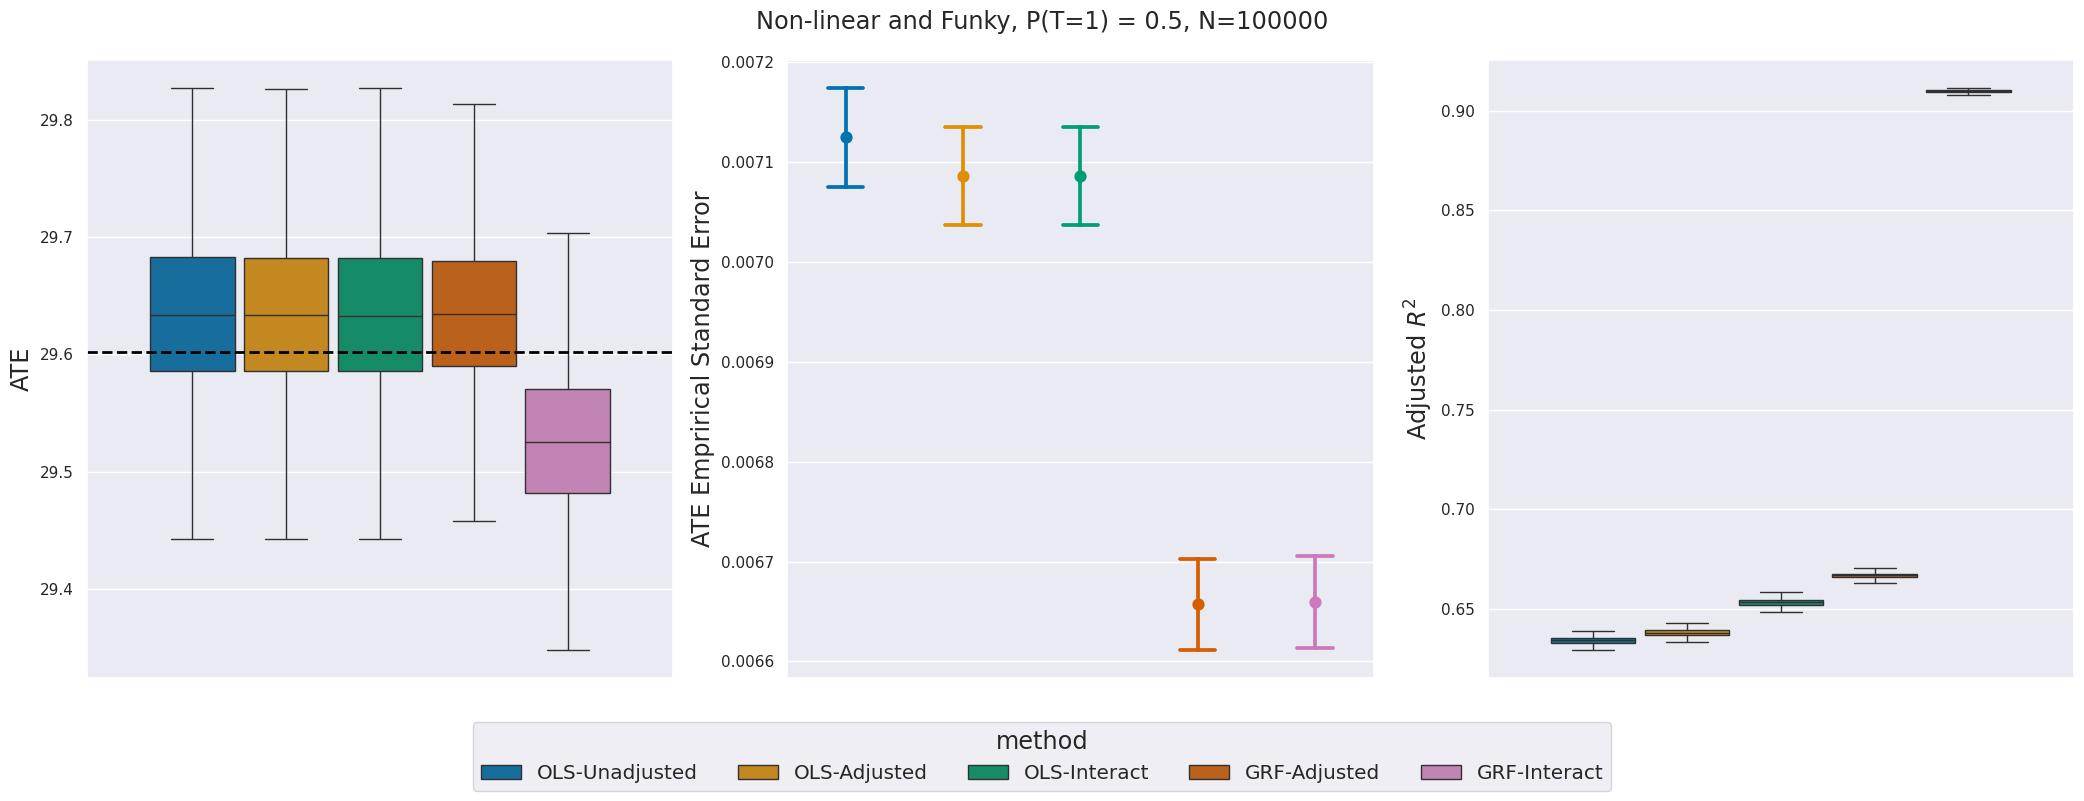

In [31]:
plot_ate(
    df=df,
    df_sem=df_sem,
    n=100000,
    balance=0.5,
    method="Non-linear and Funky",
    ate=ate_true,
)

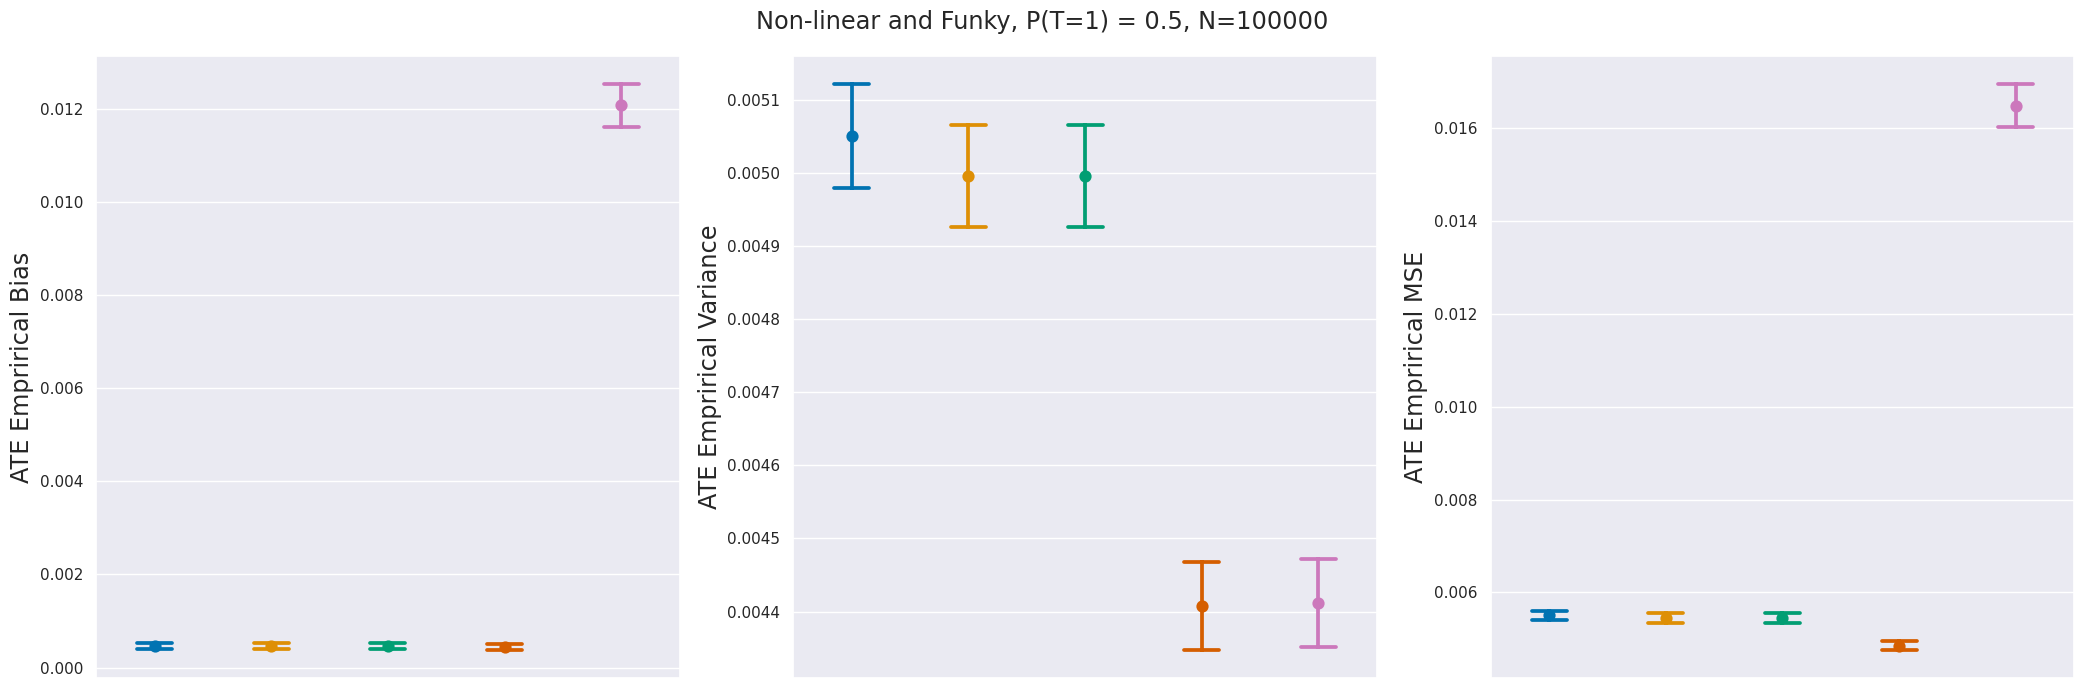

In [32]:
plot_bias(
    df_sem=df_sem,
    n=100000,
    balance=0.5,
    method="Non-linear and Funky",
)